In [2]:
# %pip install pyaudio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal as signal
from synchronisation import *
import pyaudio
import time



In [3]:
def generate_sound(samples, volume, fs): # volume range [0.0, 1.0]

    p = pyaudio.PyAudio()
    time.sleep(1)

    output_bytes = (volume * samples).tobytes()

    # for paFloat32 sample values must be in range [-1.0, 1.0]
    stream = p.open(format=pyaudio.paFloat32,
                    channels=1,
                    rate=fs,
                    output=True)

    # play. May repeat with different volume values (if done interactively)
    start_time = time.time()
    stream.write(output_bytes)
    print("Played sound for {:.2f} seconds".format(time.time() - start_time))

    stream.stop_stream()
    stream.close()

    p.terminate()

In [4]:
with open('transmitter/data_file.txt', 'r') as file:
    data = file.read().replace('\n', '')
    #data = data.replace(' ', '')
    #data = data.replace('.', '')

frequency_bin_low = 85
frequency_bin_high = 850
number_of_bins = 850 - 85 + 1
fs = 48000
N = 4096
cyclic_prefix_len = 512

data_in_binary = ''
data_in_binary += (''.join(format(ord(x), 'b').zfill(8) for x in data))
data_in_binary += ''.join(str(x) for x in ([0] * (number_of_bins*2 - len(data_in_binary) % (number_of_bins*2))))
data_in_binary = np.array(list(data_in_binary))

np.savetxt("bee_data_2.txt", data_in_binary, delimiter="", fmt='%s')
gray_mapping = np.split(data_in_binary, len(data_in_binary)/2)
#print(gray_mapping)
constelatons = []
for index, x in enumerate(gray_mapping):    
    if (x == ['0', '0']).all():
        gray_mapping[index] = (1 + 1j)/np.sqrt(2)
        constelatons.append('A')
    if (x == ['0', '1']).all():
        gray_mapping[index] = (-1 + 1j)/np.sqrt(2)
        constelatons.append('B')
    if (x == ['1', '1']).all():
        gray_mapping[index] = (-1 - 1j)/np.sqrt(2)
        constelatons.append('C')
    if (x == ['1', '0']).all():
        gray_mapping[index] = (1 - 1j)/np.sqrt(2)
        constelatons.append('D')

np.savetxt("constelations_2.txt", constelatons, delimiter="", fmt='%s')
    


symbol = np.split(np.array(gray_mapping), len(gray_mapping)/number_of_bins)
print(symbol[0].shape)

random_noise = np.random.normal(0, 1, frequency_bin_low-1) + 1j*np.random.normal(0, 1, frequency_bin_low-1)
np.savetxt("random_noise.txt", random_noise, delimiter="", fmt='%s')
random_noise_2 = np.random.normal(0, 1, int(N/2-frequency_bin_high-1)) + 1j*np.random.normal(0, 1, int(N/2-frequency_bin_high-1))
np.savetxt("random_noise_2.txt", random_noise_2, delimiter="", fmt='%s')


for index, x in enumerate(symbol):
    x = np.reshape(x, number_of_bins)
    x = np.concatenate((random_noise, x, random_noise_2), axis=None)
    #x = np.pad(x, (1000, 0), "constant", constant_values=(1, 1))
    conj = np.conjugate(x)[::-1]
    symbol[index] = np.concatenate((x, conj), axis=None)
    symbol[index] = np.insert(symbol[index], 0, 0)
    symbol[index] = np.insert(symbol[index], 2048, 0)

print(len(symbol[0]))
info = np.fft.ifft(symbol) # should I iDFT the whole block or iDFT each 1024 symbol, is there a difference?
output = open("info.txt", "w")
df = pd.DataFrame(info[0])
df.to_csv("info.csv", header=False, index=False)

print(info.shape)
to_transmit = np.zeros(shape=(len(info), N+cyclic_prefix_len))

for index, x in enumerate(info):
    cyclic_prefix = x[-cyclic_prefix_len:]
    new_x = np.concatenate((cyclic_prefix, x), axis = None)
    to_transmit[index] = new_x

print(to_transmit.shape)

to_transmit= to_transmit[0:150]
for i in range(to_transmit.shape[0]):
    to_transmit[i] = to_transmit[i] / np.max(np.abs(to_transmit[i]))

to_transmit = np.concatenate(to_transmit, axis=None)
print(to_transmit.shape)

(766,)
4096
(252, 4096)
(252, 4608)
(691200,)


C:\Users\Yuxuan Xie\AppData\Local\Temp\ipykernel_6984\3481918436.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  to_transmit[index] = new_x


In [5]:
fs = 48000
chirp_time = 2
t = np.linspace(0, chirp_time, fs*chirp_time)
f_0 = 1000
f_1 = 16000
chirp = signal.chirp(t, f0=f_0, f1=f_1, t1=chirp_time, method='linear')
chirp = chirp / np.max(np.abs(chirp)) * 0.1

"""symbol = []
for i in range(511):
    if i <100:
        symbol.append(1+1j)
    elif 100<i<200:
        symbol.append(-1+1j)
    elif 300<i<400:
        symbol.append(1-1j)
    else:
        symbol.append(-1-1j)"""


"""symbol = np.array(symbol)
conj_symbol = np.conj(symbol)[::-1]
symbol = np.concatenate((symbol, conj_symbol))
symbol = np.insert(symbol, 0, 0)
symbol = np.insert(symbol, 512, 0)
print(symbol.shape)
time_symbol = np.fft.ifft(symbol)
plt.plot(time_symbol)
plt.show()
print(time_symbol.shape)
time_symbol = np.real(time_symbol)
time_symbol = time_symbol / np.max(np.abs(time_symbol))
cyclic = np.concatenate((time_symbol[-32:], time_symbol))

symbol_data = []
for i in range(511):
    if i % 4 == 3:
        symbol_data.append(1+1j)
    elif i % 4 == 2:
        symbol_data.append(-1+1j)
    elif i % 4 == 1:
        symbol_data.append(1-1j)
    elif i % 4 == 0:
        symbol_data.append(-1-1j)

symbol_data = np.array(symbol_data)
conj_symbol_data = np.conj(symbol_data)[::-1]
symbol_data = np.concatenate((symbol_data, conj_symbol_data))
symbol_data = np.insert(symbol_data, 0, 0)
symbol_data = np.insert(symbol_data, 512, 0)
print(symbol_data.shape)
time_symbol_data = np.fft.ifft(symbol_data)
print(time_symbol_data.shape)
time_symbol_data = np.real(time_symbol_data)
time_symbol_data = time_symbol_data / np.max(np.abs(time_symbol_data))
cyclic_data = np.concatenate((time_symbol_data[-32:], time_symbol_data))
print(cyclic_data.shape)"""

'symbol = np.array(symbol)\nconj_symbol = np.conj(symbol)[::-1]\nsymbol = np.concatenate((symbol, conj_symbol))\nsymbol = np.insert(symbol, 0, 0)\nsymbol = np.insert(symbol, 512, 0)\nprint(symbol.shape)\ntime_symbol = np.fft.ifft(symbol)\nplt.plot(time_symbol)\nplt.show()\nprint(time_symbol.shape)\ntime_symbol = np.real(time_symbol)\ntime_symbol = time_symbol / np.max(np.abs(time_symbol))\ncyclic = np.concatenate((time_symbol[-32:], time_symbol))\n\nsymbol_data = []\nfor i in range(511):\n    if i % 4 == 3:\n        symbol_data.append(1+1j)\n    elif i % 4 == 2:\n        symbol_data.append(-1+1j)\n    elif i % 4 == 1:\n        symbol_data.append(1-1j)\n    elif i % 4 == 0:\n        symbol_data.append(-1-1j)\n\nsymbol_data = np.array(symbol_data)\nconj_symbol_data = np.conj(symbol_data)[::-1]\nsymbol_data = np.concatenate((symbol_data, conj_symbol_data))\nsymbol_data = np.insert(symbol_data, 0, 0)\nsymbol_data = np.insert(symbol_data, 512, 0)\nprint(symbol_data.shape)\ntime_symbol_data 

In [6]:
to_transmit = to_transmit[-691200:]
to_transmit = np.concatenate((chirp, to_transmit), axis=None)
to_transmit = to_transmit.astype(np.float32)
print(to_transmit.shape)
print(np.max(np.abs(to_transmit)))





(787200,)
1.0


In [7]:
generate_sound(to_transmit, 1, fs)

Played sound for 16.43 seconds


In [8]:
#Signal Import
data = pd.read_csv('data.txt').to_numpy()
data = np.reshape(data, len(data)) 
y = data

224691


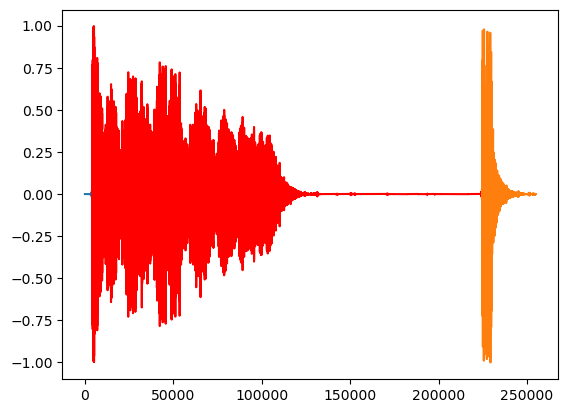

In [9]:
#Synchronization
chirp_time = 5
fs = 44100
t = np.linspace(0, chirp_time, fs*chirp_time)
f_0 = 1000
f_1 = 16000
chirp = signal.chirp(t, f0=f_0, f1=f_1, t1=chirp_time, method='linear')
max_index, cross_correlation, lags = matched_filter_synchronisation(y,chirp, 10, fs)
print(max_index)

#Plot
x = np.linspace(0, len(y), len(y))
plt.plot(x[:lags[max_index]],y[:lags[max_index]])
plt.plot(x[lags[max_index]:lags[max_index] + len(chirp)],y[lags[max_index]:lags[max_index] + len(chirp)], color = 'red')
plt.plot(x[lags[max_index] + len(chirp):], y[lags[max_index] + len(chirp):])
plt.show()


c:\Users\Yuxuan Xie\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


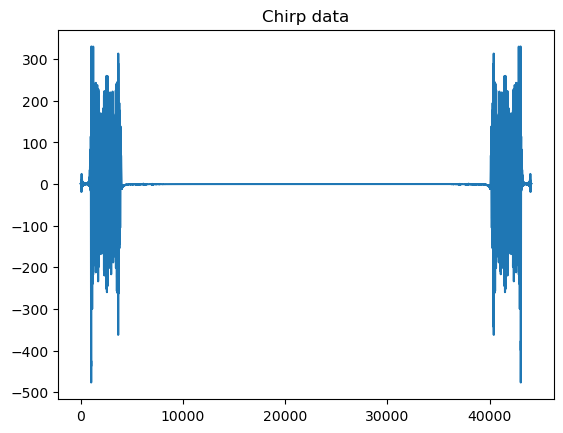

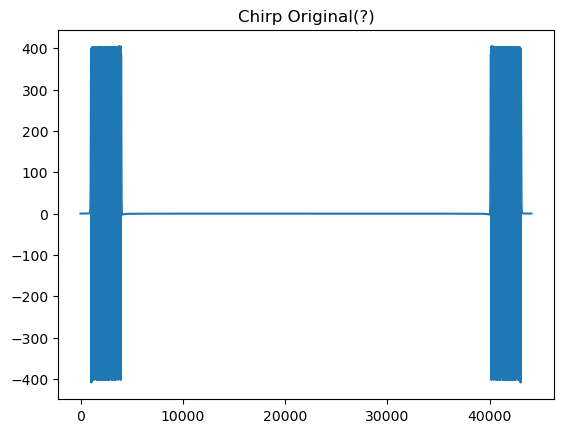

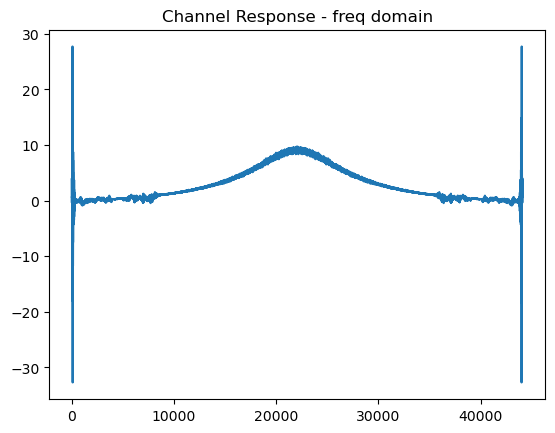

[-0.00604179-3.69586216e-14j -0.01209055+2.68157620e-14j
 -0.01673703-1.23857845e-14j  0.01258094-7.02022374e-15j
 -0.89932371+2.61152894e-14j]


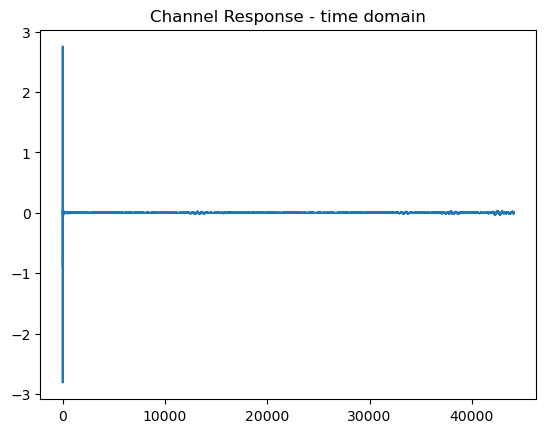

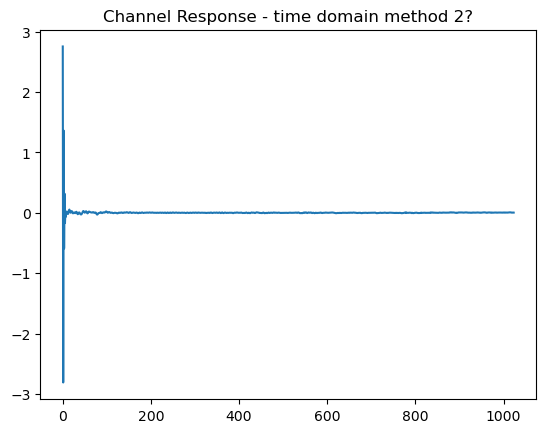

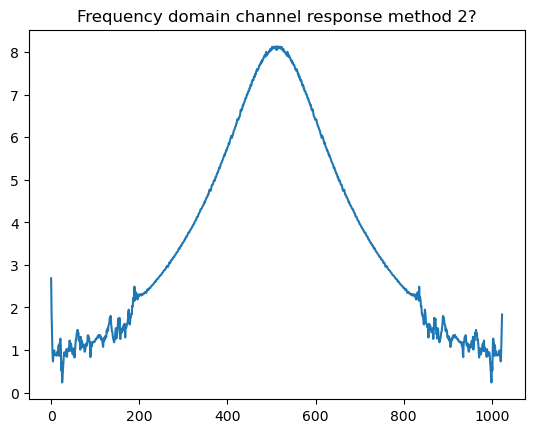

In [10]:
# Channel estimation using the chirp
chirp_data = y[lags[max_index]:lags[max_index] + len(chirp)]
channel_chirp = standered_estimation(chirp, chirp_data, fs)

plt.plot(np.fft.fft(chirp_data, n = 44100))
plt.title("Chirp data")
plt.show()

plt.plot(np.fft.fft(chirp, n = 44100))
plt.title("Chirp Original(?)")
plt.show()

channel_freq = np.fft.fft(chirp_data, n = 44100)/np.fft.fft(chirp, n = 44100)
channel_time = np.fft.ifft(channel_freq, n = 44100)

plt.plot(channel_freq)
plt.title("Channel Response - freq domain")
plt.show()
print(channel_time[-5:])
channel_time = np.roll(channel_time, 1)
plt.plot(channel_time)
plt.title("Channel Response - time domain")
plt.show()


# plt.plot(channel_chirp) ... - I think this is the same as channel_freq?
# plt.show()

time_channel_chirp = np.fft.ifft(channel_chirp)
time_channel_chirp = np.real(time_channel_chirp)
time_channel_chirp = time_channel_chirp[:1024]
plt.plot(time_channel_chirp)
plt.title("Channel Response - time domain method 2?")
plt.show()
chanel_estimation = np.fft.fft(time_channel_chirp, n=1024)
plt.plot(np.abs(chanel_estimation))
plt.title("Frequency domain channel response method 2?")
plt.show()

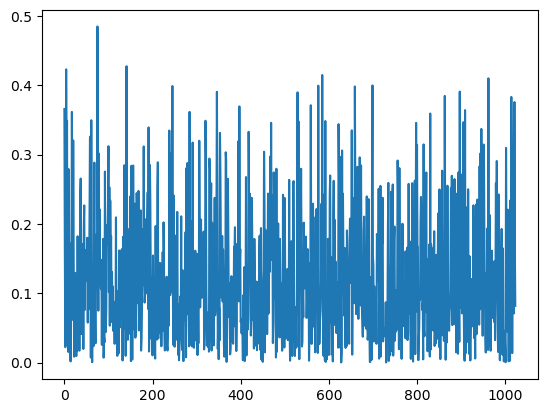

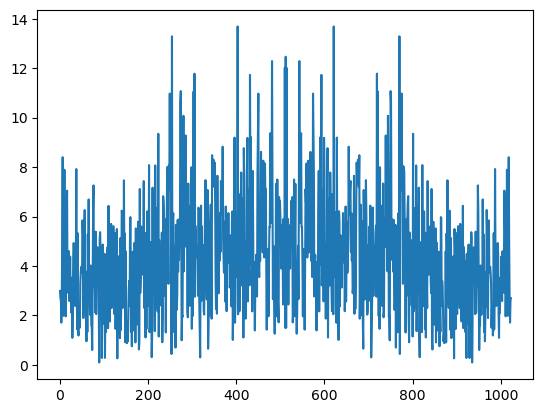

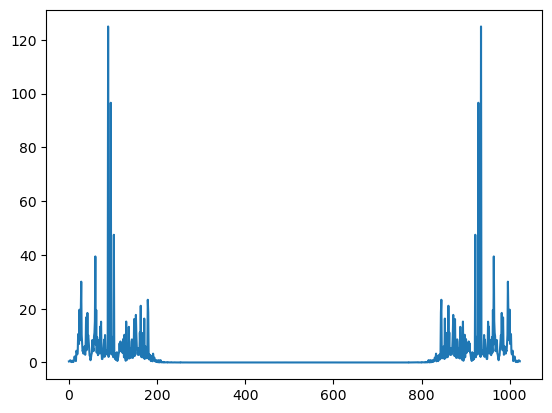

[-0.02128892+7.03864050e-16j -0.02873936-9.19403442e-17j
 -0.04578971-6.72639028e-16j ... -0.0837581 +6.79144241e-16j
 -0.07226568+9.97465999e-16j -0.04145385+1.10935566e-15j]


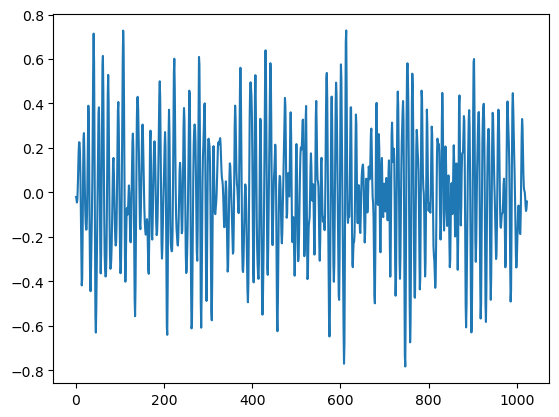

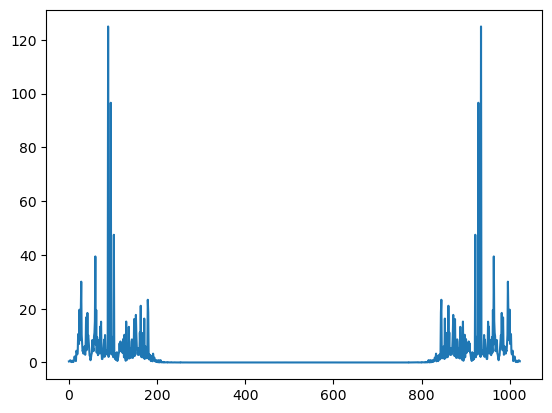

In [11]:
# Channel estimation Using OFDM
n = 1056
#OFDM_DATA = pd.read_csv('OFDM_DATA.csv').to_numpy()
OFDM_DATA = to_transmit[len(chirp) +32: len(chirp) + 1056]
plt.plot(np.abs(OFDM_DATA))
plt.show()
plt.plot(np.abs(np.fft.fft(OFDM_DATA)))
plt.show()
Start_index = lags[max_index] + len(chirp) 

# Channel estimation
Symbol_One = y[Start_index:Start_index + n]

Symbol_One = Symbol_One[32:]

chanel_estimation_2 = standered_estimation(OFDM_DATA, Symbol_One, 1024)
plt.plot(np.abs(chanel_estimation_2))
plt.show()
time_channel_2 = np.fft.ifft(chanel_estimation_2)
"""time_channel_2 = time_channel_2[200:]
time_channel_2 = np.pad(time_channel_2, (0, 824), "constant", constant_values=(0, 0))""" #TO BE DONE -  FIR TIME TO BE EXPANDED
chanel_estimation_2 = np.fft.fft(time_channel_2, n=1024)
print(time_channel_2)
plt.plot((time_channel_2))
plt.show()
plt.plot(np.abs(chanel_estimation_2))
plt.show()


220500
221556
224692
(1024,)
[-2.29997   +0.j         -2.30109504+0.08711356j -2.37027114+0.18869119j
 ... -2.30503169-0.26731809j -2.37027114-0.18869119j
 -2.30109504-0.08711356j]
[2.68570783+0.j         1.82791032-0.16238054j 1.39805834+0.2127206j  ...
 0.91124812-0.31303169j 1.39805834-0.2127206j  1.82791032+0.16238054j]
(1024,)
(511,)
511


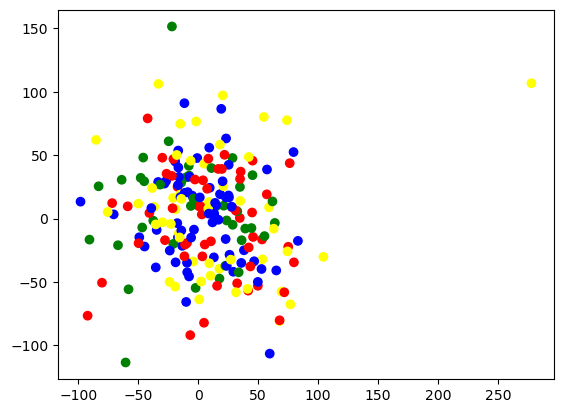

In [12]:
Start_index = lags[max_index] + len(chirp) 
print(len(chirp))
print(len(chirp) + 1056)
print(Start_index)
n = 1056
index = 3
Symbol_Two = y[Start_index + index*n :Start_index + (index+1)*n]
Symbol_Two = Symbol_Two[32:]
print(Symbol_Two.shape)
Symbol_Two = np.fft.fft(Symbol_Two, n = 1024)
print(Symbol_Two)
print(chanel_estimation)
print(chanel_estimation.shape)
Symbol_Two_correct = Symbol_Two / chanel_estimation
Symbol_Two_correct_2 = Symbol_Two / chanel_estimation_2

"""colours = []
data = to_transmit[len(chirp) +32 + index * 1056: len(chirp) + 1056 + index * 1056]
data = np.reshape(data, len(data))
print(data.shape)
data = np.fft.fft(data, n = 1024)
constelatons = []

for x in data[1:512]:
    if np.real(x) > 0 and np.imag(x) > 0:
        colours.append('red')
        constelatons.append('A')
    elif np.real(x) < 0 and np.imag(x) > 0:
        colours.append('blue')
        constelatons.append('B')
    elif np.real(x) < 0 and np.imag(x) < 0:
        colours.append('green')
        constelatons.append('C')
    elif np.real(x) > 0 and np.imag(x) < 0:
        colours.append('yellow')
        constelatons.append('D')

constelatons = np.array(constelatons)
decoded_symbol_two = []
for x in Symbol_Two_correct_2[1:512]:
    if np.real(x) > 0 and np.imag(x) > 0:
        decoded_symbol_two.append('A')
    elif np.real(x) < 0 and np.imag(x) > 0:
        decoded_symbol_two.append('B')
    elif np.real(x) < 0 and np.imag(x) < 0:
        decoded_symbol_two.append('C')
    elif np.real(x) > 0 and np.imag(x) < 0:
        decoded_symbol_two.append('D')

decoded_symbol_two = np.array(decoded_symbol_two)
comparison = np.vstack((colours, decoded_symbol_two, Symbol_Two_correct_2[1:512]))"""

constelatons = np.loadtxt("constelations.txt", dtype=str)
constelatons = constelatons[index*511:(index+1)*511]
colours = []
for i in constelatons:
    if i == 'A':
        colours.append('red')
    if i == 'B':
        colours.append('blue')
    if i == 'C':
        colours.append('green')
    if i == 'D':
        colours.append('yellow')


#print(Symbol_Two_correct_2[400:450])
print(Symbol_Two_correct_2[1:512].shape)
print(len(colours))
index = 300
index_2 = 511
#print(comparison[:, index:index_2])
#print(Symbol_Two_correct_2[index+1:index_2+1])
plt.scatter(np.real(Symbol_Two_correct_2[index+1:index_2+1]), np.imag(Symbol_Two_correct_2[index+1:index_2+1]), c = colours[index:index_2])


In [13]:
with open('transmitter/data_file.txt', 'r') as file:
    data = file.read().replace('\n', '')
    #data = data.replace(' ', '')
    #data = data.replace('.', '')

print(data)
print(type(bytearray(data, 'ascii')))

data_in_binary = ''
data_in_binary += (''.join(format(ord(x), 'b').zfill(8) for x in data))
data_in_binary += ''.join(str(x) for x in ([0] * (1022 - len(data_in_binary) % 1022)))
data_in_binary = np.array(list(data_in_binary))

np.savetxt("bee_data.txt", data_in_binary, delimiter="", fmt='%s')
print(data_in_binary)
print(len(data_in_binary))
gray_mapping = np.split(data_in_binary, len(data_in_binary)/2)
#print(gray_mapping)
constelatons = []
for index, x in enumerate(gray_mapping):
    if index == 0:
        print(x)
        assert (x == ['0', '1']).all()
    
    if (x == ['0', '0']).all():
        gray_mapping[index] = (1 + 1j)/np.sqrt(2)
        constelatons.append('A')
    if (x == ['0', '1']).all():
        gray_mapping[index] = (-1 + 1j)/np.sqrt(2)
        constelatons.append('B')
        #print((-1 + 1j)/np.sqrt(2))
    if (x == ['1', '1']).all():
        gray_mapping[index] = (-1 - 1j)/np.sqrt(2)
        constelatons.append('C')
    if (x == ['1', '0']).all():
        gray_mapping[index] = (1 - 1j)/np.sqrt(2)
        constelatons.append('D')

np.savetxt("constelations.txt", constelatons, delimiter="", fmt='%s')
    



print(np.array(gray_mapping))
print(len(gray_mapping))
print(len(data_in_binary))
symbol = np.split(np.array(gray_mapping), len(gray_mapping)/511)


for index, x in enumerate(symbol):
    x = np.reshape(x, 511)
    #x = np.pad(x, (1000, 0), "constant", constant_values=(1, 1))
    conj = np.conjugate(x)[::-1]
    symbol[index] = np.concatenate((x, conj), axis=None)
    symbol[index] = np.insert(symbol[index], 0, 0)
    symbol[index] = np.insert(symbol[index], 512, 0)

print(len(symbol[0]))
print(symbol[0])
info = np.fft.ifft(symbol) # should I iDFT the whole block or iDFT each 1024 symbol, is there a difference?
output = open("info.txt", "w")
df = pd.DataFrame(info[0])
df.to_csv("info.csv", header=False, index=False)

print(info.shape)
to_transmit_2 = np.zeros(shape=(len(info), 1056))

for index, x in enumerate(info):
    cyclic_prefix = x[-32:]
    new_x = np.concatenate((cyclic_prefix, x), axis = None)
    to_transmit_2[index] = new_x

for i in range(len(to_transmit_2)):
    to_transmit_2[i] = to_transmit_2[i] / np.max(np.abs(to_transmit_2[i]))

to_transmit_2 = np.concatenate(to_transmit_2, axis=None)
print(to_transmit_2.shape)

According to all known laws of aviation, there is no way a bee should be able to fly.Its wings are too small to get its fat little body off the ground.The bee, of course, flies anyway because bees don't care what humans think is impossible.Yellow, black. Yellow, black. Yellow, black. Yellow, black.Ooh, black and yellow!Let's shake it up a little.Barry! Breakfast is ready!Coming!Hang on a second.Hello?Barry?Adam?Can you believe this is happening?I can't.I'll pick you up.Looking sharp.Use the stairs, Your father paid good money for those.Sorry. I'm excited.Here's the graduate.We're very proud of you, son.A perfect report card, all B's.Very proud.Ma! I got a thing going here.You got lint on your fuzz.Ow! That's me!Wave to us! We'll be in row 118,000.Bye!Barry, I told you, stop flying in the house!Hey, Adam.Hey, Barry.Is that fuzz gel?A little. Special day, graduation.Never thought I'd make it.Three days grade school, three days high school.Those were awkward.Three days college. I'm glad I

C:\Users\Yuxuan Xie\AppData\Local\Temp\ipykernel_6984\3168893700.py:71: ComplexWarning: Casting complex values to real discards the imaginary part
  to_transmit_2[index] = new_x


In [14]:
fs = 44100
chirp_time = 5
t = np.linspace(0, chirp_time, fs*chirp_time)
f_0 = 1000
f_1 = 22000
chirp = signal.chirp(t, f0=f_0, f1=f_1, t1=chirp_time, method='linear')
chirp = chirp / np.max(np.abs(chirp)) * 0.05
chirp = chirp.astype(np.float32)
one_second = np.zeros(44100)
transmit = np.concatenate((chirp, one_second, to_transmit_2), axis=None)
transmit = transmit.astype(np.float32)
print(transmit.shape)

(662712,)


In [15]:
#generate_sound(transmit, 1, fs)

Read data2.txt (5-second chirp + 377 OFDM bee)

In [16]:
#Import recorded signal
data = pd.read_csv('data2.txt').to_numpy()
data = np.reshape(data, len(data)) 
y = data
print(y.shape)

(629759,)


223664


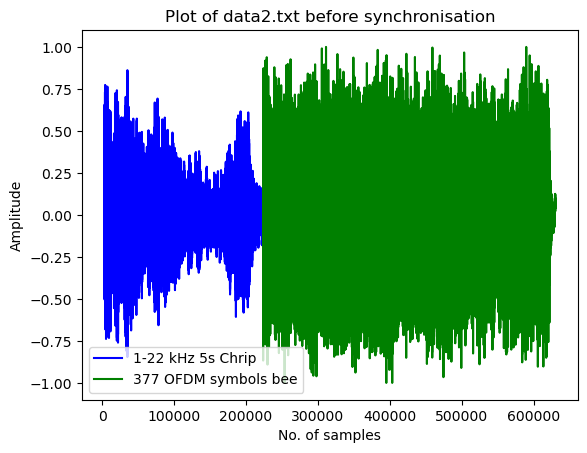

In [17]:
#Synchronization
chirp_time = 5
fs = 44100
t = np.linspace(0, chirp_time, fs*chirp_time)
f_0 = 1000
f_1 = 22000
chirp = signal.chirp(t, f0=f_0, f1=f_1, t1=chirp_time, method='linear')
max_index, cross_correlation, lags = matched_filter_synchronisation(y,chirp, 10, fs)
print(max_index)

#Plot
x = np.linspace(0, len(y), len(y))
# plt.plot(x[:lags[max_index]],y[:lags[max_index]])
plt.plot(x[lags[max_index]:lags[max_index] + len(chirp)],y[lags[max_index]:lags[max_index] + len(chirp)], color = 'b', label='1-22 kHz 5s Chrip')
plt.plot(x[lags[max_index] + len(chirp):], y[lags[max_index] + len(chirp):], color = 'green', label='377 OFDM symbols bee')
plt.xlabel("No. of samples")
plt.ylabel("Amplitude")
plt.title("Plot of data2.txt before synchronisation")
plt.legend()
plt.show()

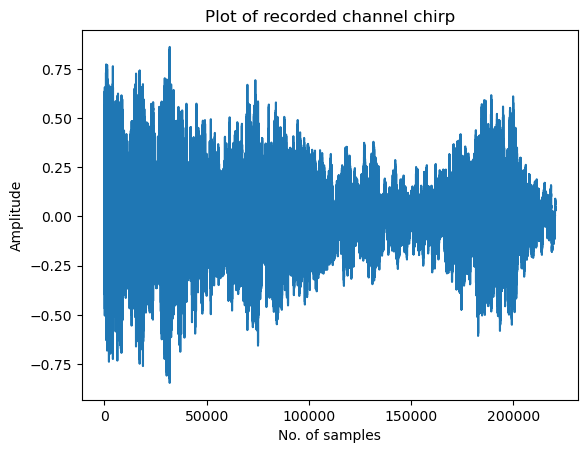

c:\Users\Yuxuan Xie\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


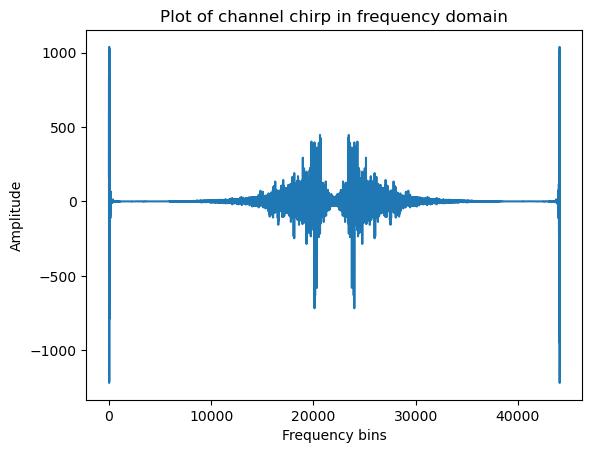

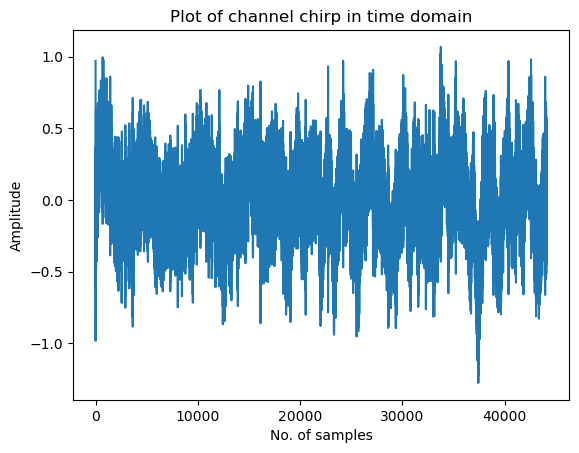

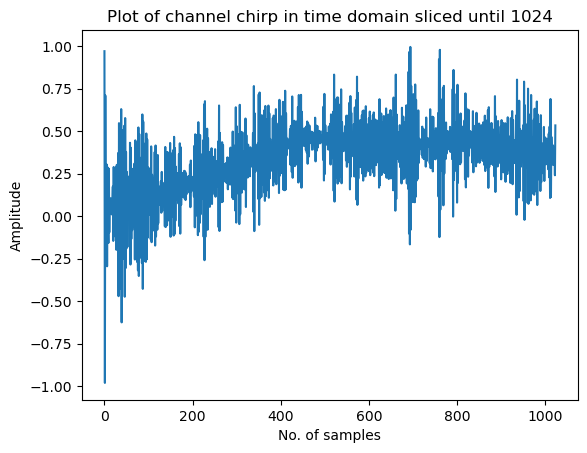

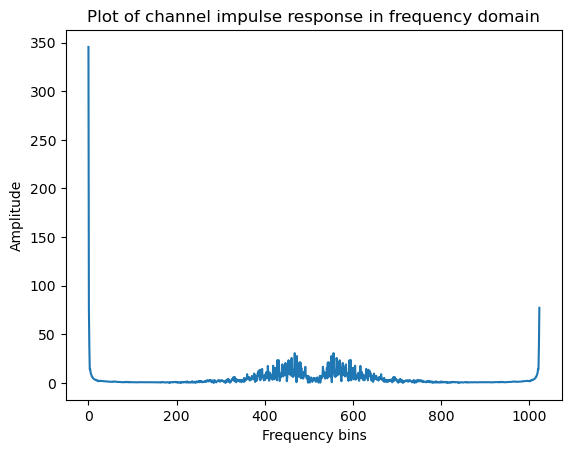

In [18]:
# Channel estimation using the chirp
chirp_data = y[lags[max_index]:lags[max_index] + len(chirp)] # lags[max_index] is where the chirp starts
plt.plot(chirp_data)
plt.xlabel("No. of samples")
plt.ylabel("Amplitude")
plt.title("Plot of recorded channel chirp")
plt.show()

channel_chirp = standered_estimation(chirp, chirp_data, fs) # calculate channel coefficients in the frequency domain

plt.plot(channel_chirp)
plt.xlabel("Frequency bins")
plt.ylabel("Amplitude")
plt.title("Plot of channel chirp in frequency domain")
plt.show()

channel_time = np.fft.ifft(channel_chirp)
plt.plot(channel_time)
plt.xlabel("No. of samples")
plt.ylabel("Amplitude")
plt.title("Plot of channel chirp in time domain")
plt.show()

channel_time = channel_time[:1024]
plt.plot(channel_time)
plt.xlabel("No. of samples")
plt.ylabel("Amplitude")
plt.title("Plot of channel chirp in time domain sliced until 1024")
plt.show()


channel_freq = np.fft.fft(channel_time, n = 1024)
plt.plot(np.abs(channel_freq))
plt.xlabel("Frequency bins")
plt.ylabel("Amplitude")
plt.title("Plot of channel impulse response in frequency domain")
plt.show()

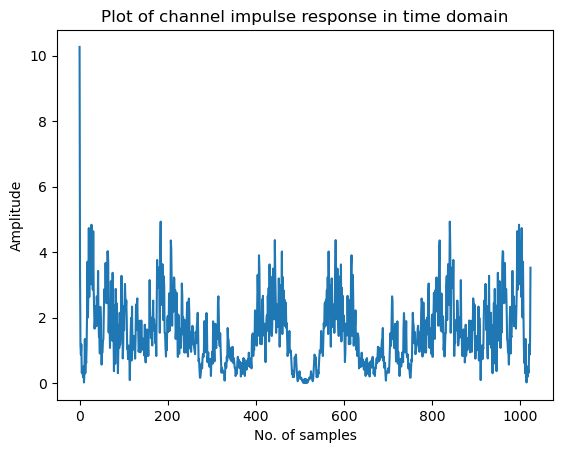

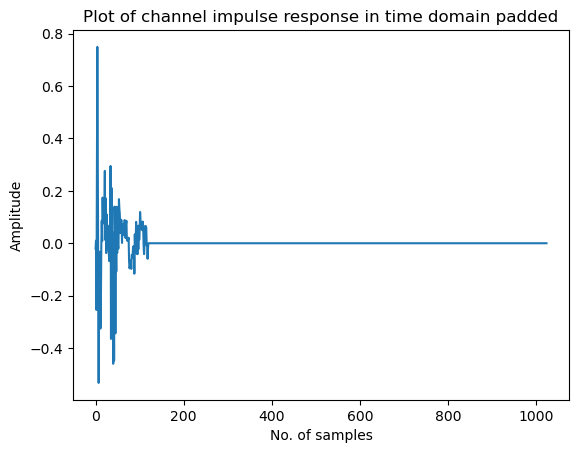

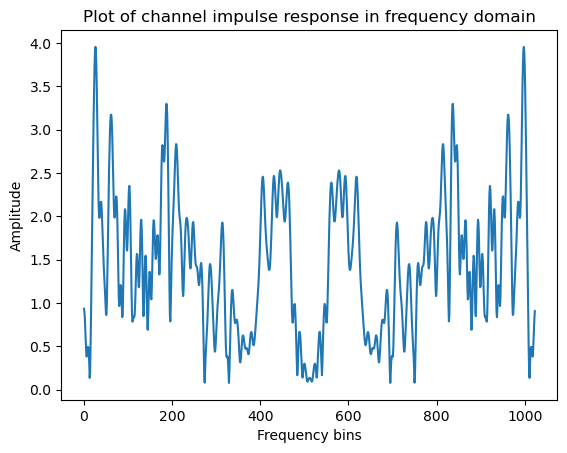

In [19]:
# Channel estimation Using OFDM
n = 1056
#OFDM_DATA = pd.read_csv('OFDM_DATA.csv').to_numpy()
OFDM_DATA = to_transmit_2[32: 1056] # first OFDM symbol - cyclic prefix of bee

Start_index = lags[max_index] + len(chirp)

# Channel estimation
Symbol_One = y[Start_index:Start_index + n]

Symbol_One = Symbol_One[32:]
OFDM_DATA[0] = 1
OFDM_DATA[512] = 1
chanel_estimation_2 = standered_estimation(OFDM_DATA, Symbol_One, 1024)
plt.plot(np.abs(chanel_estimation_2))
plt.xlabel("No. of samples")
plt.ylabel("Amplitude")
plt.title("Plot of channel impulse response in time domain")
plt.show()

time_channel_2 = np.fft.ifft(chanel_estimation_2, n=1024)
filter = 120
time_channel_2 = time_channel_2[:filter]
time_channel_2 = np.pad(time_channel_2, (0, 1024 - filter), "constant", constant_values=(0, 0)) #TO BE DONE -  FIR TIME TO BE EXPANDED
chanel_estimation_2 = np.fft.fft(time_channel_2, n=1024)
plt.plot((time_channel_2))
plt.xlabel("No. of samples")
plt.ylabel("Amplitude")
plt.title("Plot of channel impulse response in time domain padded")
plt.show()

plt.plot(np.abs(chanel_estimation_2))
plt.xlabel("Frequency bins")
plt.ylabel("Amplitude")
plt.title("Plot of channel impulse response in frequency domain")
plt.show()

Plot decoded constellation stars

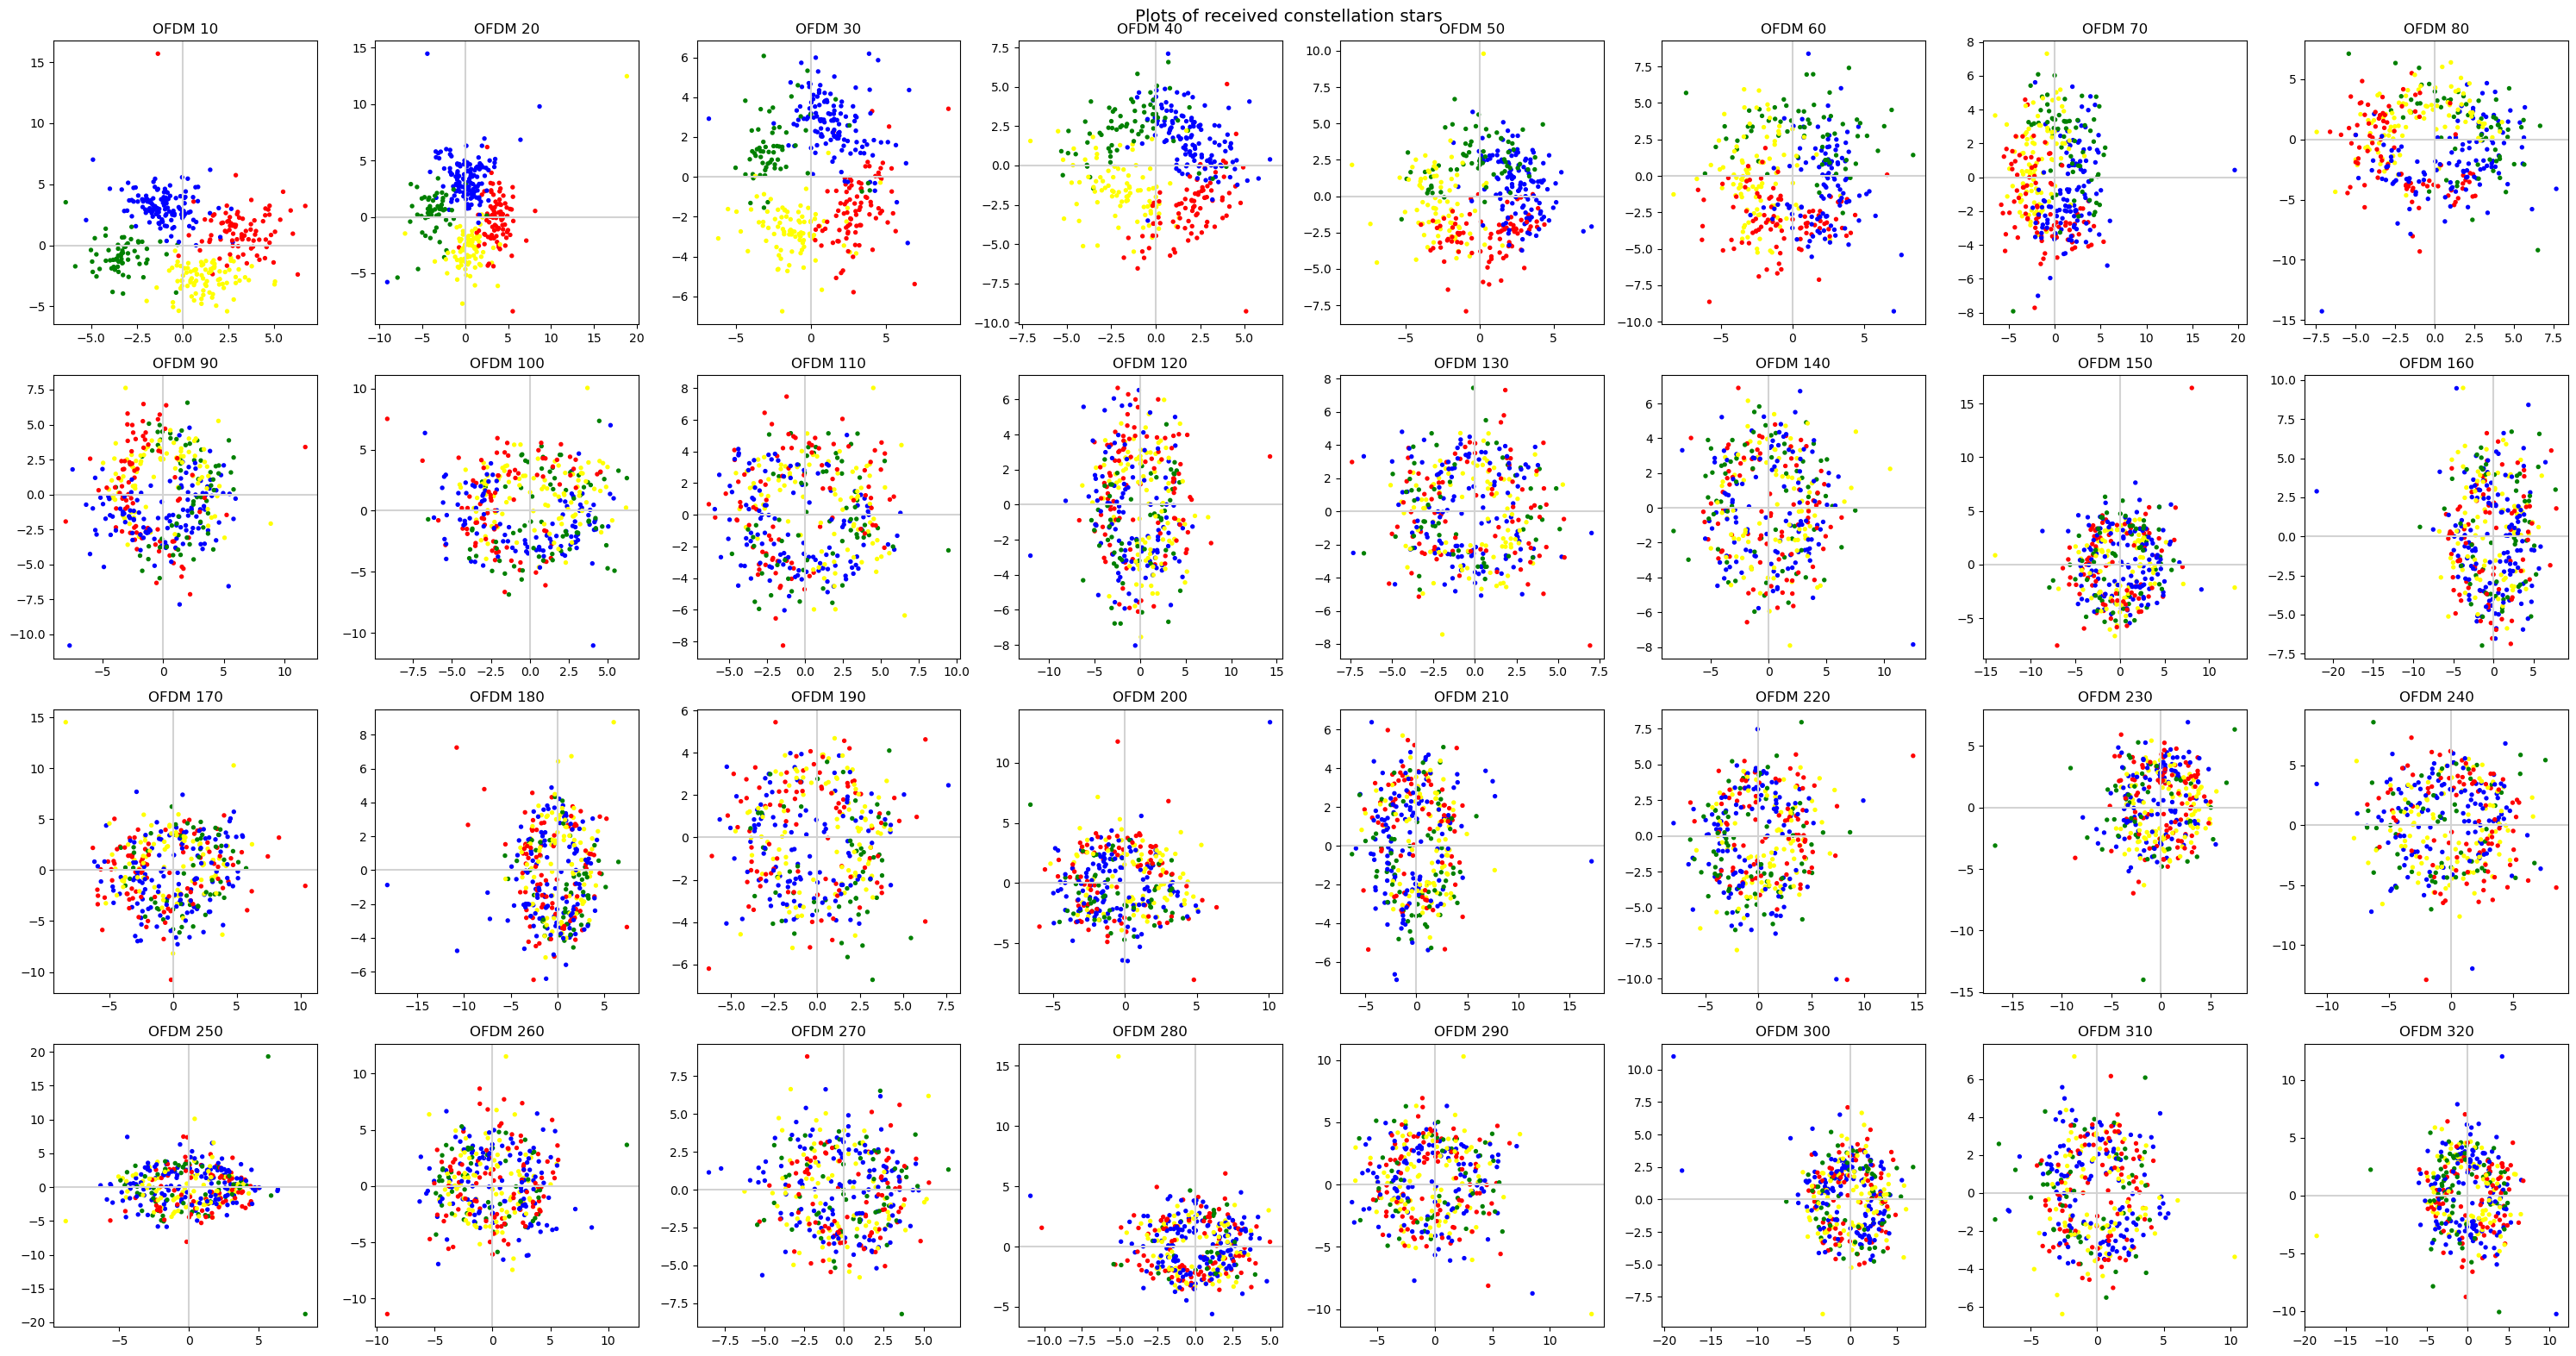

In [20]:
Start_index = lags[max_index] + len(chirp)

n = 1056

# Indices to plot
indices = range(1,33) # OFDM symbol index 
indices = [i * 10 for i in indices]

# Create a figure with 7 subplots horizontally
fig, axes = plt.subplots(4, 8, figsize=(30, 16))
axes = axes.flatten()

# Loop through each index and plot the scatter plot on the corresponding subplot
for ax, index in zip(axes, indices):
    Symbol_Two = y[Start_index + index*n :Start_index + (index+1)*n]
    Symbol_Two = Symbol_Two[32:]
    Symbol_Two = np.fft.fft(Symbol_Two, n = 1024)
    Symbol_Two_correct = Symbol_Two / chanel_estimation
    Symbol_Two_correct_2 = Symbol_Two / chanel_estimation_2

    constelatons = np.loadtxt("constelations.txt", dtype=str) # transmitted bee.txt data constellation stars
    constelatons = constelatons[index*511:(index+1)*511]
    colours = []
    for i in constelatons:
        if i == 'A':
            colours.append('red')
        if i == 'B':
            colours.append('blue')
        if i == 'C':
            colours.append('green')
        if i == 'D':
            colours.append('yellow')

    # index within one OFDM symbol
    index_1 = 150
    index_2 = 511

    ax.scatter(np.real(Symbol_Two_correct_2[index_1+1:index_2+1]), np.imag(Symbol_Two_correct_2[index_1+1:index_2+1]), c=colours[index_1:index_2], s=8)
    ax.axhline(y=0, color='lightgrey')
    ax.axvline(x=0, color='lightgrey')
    ax.set_title(f"OFDM {index}")

st = fig.suptitle("Plots of received constellation stars", fontsize="x-large")
plt.tight_layout()
plt.show()



Correcting smearing

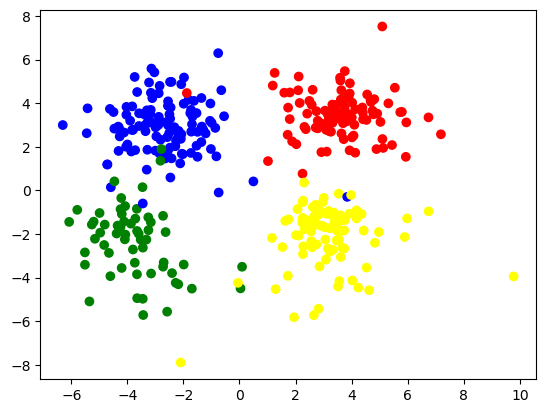

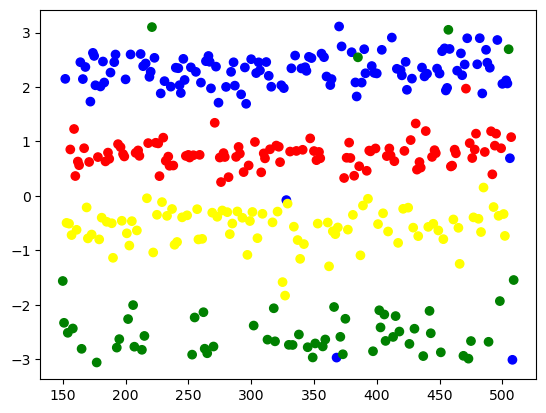

In [21]:
n = 1056
index = 0
Symbol_Two = y[Start_index + index*n :Start_index + (index+1)*n]
Symbol_Two = Symbol_Two[32:]
Symbol_Two = np.fft.fft(Symbol_Two, n = 1024)
Symbol_Two_correct = Symbol_Two / chanel_estimation
Symbol_Two_correct_2 = Symbol_Two / chanel_estimation_2

constelatons = np.loadtxt("constelations.txt", dtype=str)
# print(len(constelatons))
constelatons = constelatons[index*511:(index+1)*511]
colours = []
for i in constelatons:
    if i == 'A':
        colours.append('red')
    if i == 'B':
        colours.append('blue')
    if i == 'C':
        colours.append('green')
    if i == 'D':
        colours.append('yellow')

index_1 = 150
index_2 = 510

plt.scatter(np.real(Symbol_Two_correct_2[index_1+1:index_2+1]), np.imag(Symbol_Two_correct_2[index_1+1:index_2+1]), c = colours[index_1:index_2])
plt.show()


list_phase = []
for x in range(index_1,index_2):
    phase = np.angle(Symbol_Two_correct_2[x+1])
    list_phase.append(phase)
frequency_bins = np.arange(index_1, index_2, 1).tolist()
plt.scatter(frequency_bins, list_phase, c = colours[index_1:index_2])
plt.show()


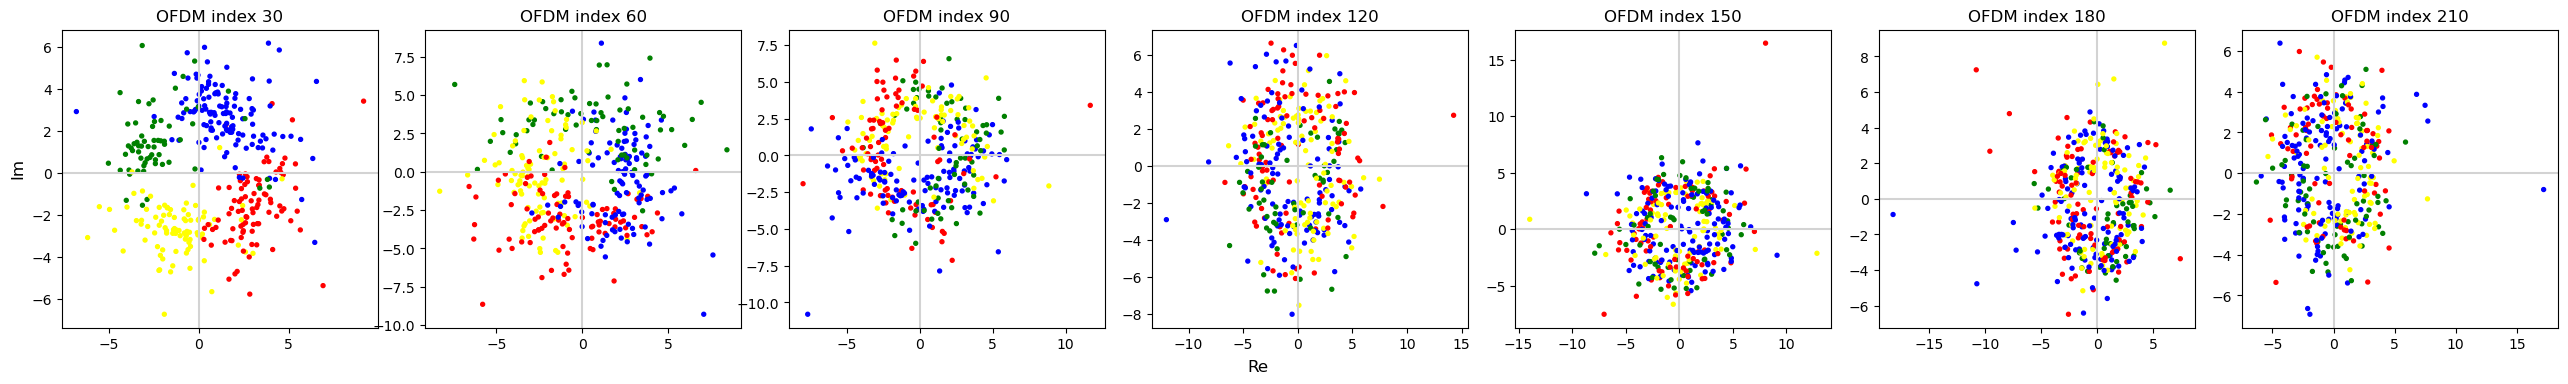

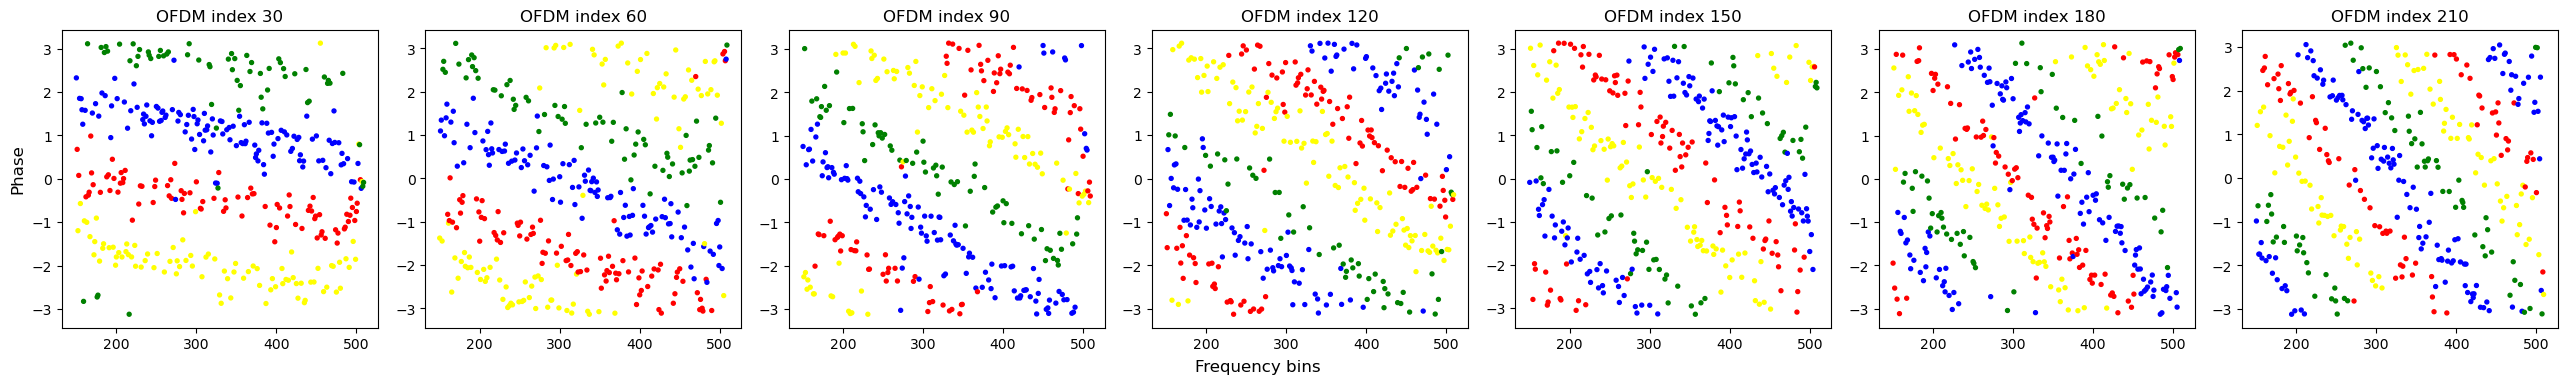

In [22]:
indices = range(1, 8) # OFDM symbol index 
indices = [i * 30 for i in indices]
# indices = [1, 3, 10, 20, 50, 100, 200, 376]
# index within one OFDM symbol
index_1 = 150
index_2 = 510

# Create a figure with 7 subplots horizontally
fig, axes = plt.subplots(1, 7, figsize=(26, 4.2))
axes = axes.flatten()

# Loop through each index and plot the scatter plot on the corresponding subplot
for ax, index in zip(axes, indices):
    Symbol_Two = y[Start_index + index*n :Start_index + (index+1)*n]
    Symbol_Two = Symbol_Two[32:]
    Symbol_Two = np.fft.fft(Symbol_Two, n = 1024)
    Symbol_Two_correct = Symbol_Two / chanel_estimation
    Symbol_Two_correct_2 = Symbol_Two / chanel_estimation_2

    constelatons = np.loadtxt("constelations.txt", dtype=str) # transmitted bee.txt data constellation stars
    constelatons = constelatons[index*511:(index+1)*511]
    colours = []
    for i in constelatons:
        if i == 'A':
            colours.append('red')
        if i == 'B':
            colours.append('blue')
        if i == 'C':
            colours.append('green')
        if i == 'D':
            colours.append('yellow')

    ax.scatter(np.real(Symbol_Two_correct_2[index_1+1:index_2+1]), np.imag(Symbol_Two_correct_2[index_1+1:index_2+1]), c=colours[index_1:index_2], s=8)
    ax.axhline(y=0, color='lightgrey')
    ax.axvline(x=0, color='lightgrey')
    ax.set_title(f"OFDM index {index}")

# st = fig.suptitle("Plots of received constellation stars", fontsize="x-large")
fig.supxlabel("Re", fontsize="large")
fig.supylabel("Im", fontsize="large")
fig.subplots_adjust(left=0.04, right=1, top=0.83, bottom=0.12, wspace=0.15)
plt.show()

# Create a figure with 7 subplots horizontally
fig, axes = plt.subplots(1, 7, figsize=(26, 4.2))
axes = axes.flatten()

# Loop through each index and plot the scatter plot on the corresponding subplot
for ax, index in zip(axes, indices):
    Symbol_Two = y[Start_index + index*n :Start_index + (index+1)*n]
    Symbol_Two = Symbol_Two[32:]
    Symbol_Two = np.fft.fft(Symbol_Two, n = 1024)
    Symbol_Two_correct = Symbol_Two / chanel_estimation
    Symbol_Two_correct_2 = Symbol_Two / chanel_estimation_2

    constelatons = np.loadtxt("constelations.txt", dtype=str) # transmitted bee.txt data constellation stars
    constelatons = constelatons[index*511:(index+1)*511]
    colours = []
    for i in constelatons:
        if i == 'A':
            colours.append('red')
        if i == 'B':
            colours.append('blue')
        if i == 'C':
            colours.append('green')
        if i == 'D':
            colours.append('yellow')

    list_phase = []
    for x in range(index_1,index_2):
        phase = np.angle(Symbol_Two_correct_2[x+1])
        list_phase.append(phase)
    frequency_bins = np.arange(index_1, index_2, 1).tolist()
    ax.scatter(frequency_bins, list_phase, c = colours[index_1:index_2], s=8)
    ax.set_title(f"OFDM index {index}")

fig.supxlabel("Frequency bins", fontsize="large")
fig.supylabel("Phase", fontsize="large")
# fig.suptitle("Phase plots constellation stars", fontsize="x-large")
fig.subplots_adjust(left=0.04, right=1, top=0.83, bottom=0.12, wspace=0.15)
plt.show()


k means to determine clusters and correct gradient for each cluster over frequency bins

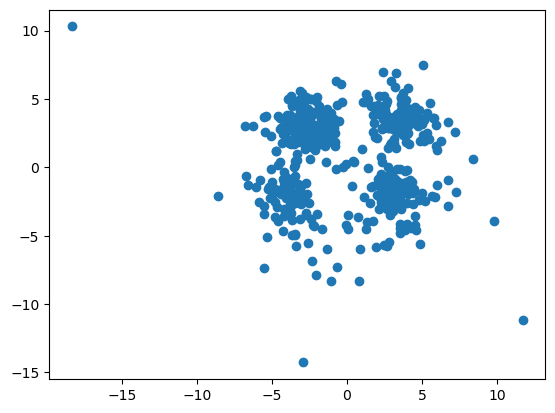

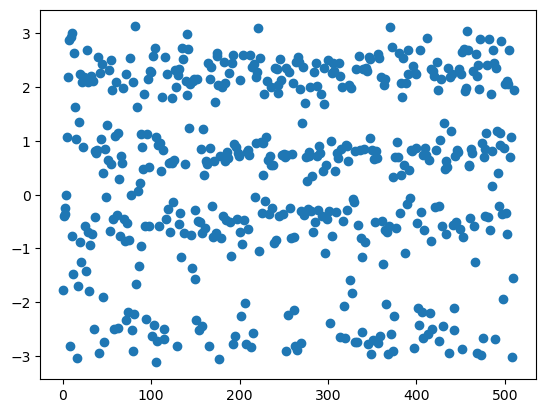

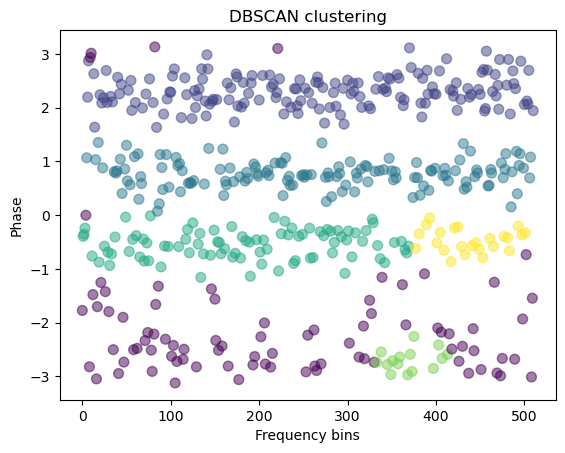

In [23]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import sklearn.mixture as mixture
import os
import warnings


# Set OMP_NUM_THREADS environment variable to 2
os.environ['OMP_NUM_THREADS'] = '2'
warnings.filterwarnings("ignore", category=UserWarning)

n = 1056
index = 0
Symbol_Two = y[Start_index + index*n :Start_index + (index+1)*n]
Symbol_Two = Symbol_Two[32:]
Symbol_Two = np.fft.fft(Symbol_Two, n = 1024)
Symbol_Two_correct = Symbol_Two / chanel_estimation
Symbol_Two_correct_2 = Symbol_Two / chanel_estimation_2

constelatons = np.loadtxt("constelations.txt", dtype=str)
# print(len(constelatons))
constelatons = constelatons[index*511:(index+1)*511]

index_1 = 0
index_2 = 511

plt.scatter(np.real(Symbol_Two_correct_2[index_1+1:index_2+1]), np.imag(Symbol_Two_correct_2[index_1+1:index_2+1]))
plt.show()

list_phase = [] # list of phase of all received data 
for x in range(index_1,index_2):
    phase = np.angle(Symbol_Two_correct_2[x+1])
    list_phase.append(phase)
frequency_bins = np.arange(index_1, index_2, 1).tolist()

plt.scatter(frequency_bins, list_phase)
plt.show()

# Reshape frequency_bins and list_phase for clustering
X = np.column_stack((frequency_bins, list_phase))
# Scale the features (frequency_bins and list_phase) to have mean=0 and variance=1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# eps: The maximum distance between two samples for one to be considered as in the neighborhood of the other
# min_samples: The number of samples (or total weight) in a neighborhood for a point to be considered as a core point
dbscan = DBSCAN(eps=0.29, min_samples=15)  # Adjust eps and min_samples as needed
inits = np.array([[250, np.pi/4], [250, 3*np.pi/4], [250, -np.pi/4], [250, -3*np.pi/4]])
#gaussian = mixture.BayesianGaussianMixture(n_components=4, weight_concentration_prior_type='dirichlet_process',  weight_concentration_prior=0.2, max_iter=1000, n_init=1, tol=1e-3, random_state=0)
#labels = gaussian.fit_predict(X_scaled)
labels = dbscan.fit_predict(X_scaled)

# Plot the data points colored according to the cluster they are assigned to
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50, alpha=0.5)
plt.xlabel('Frequency bins')
plt.ylabel('Phase')
plt.title('DBSCAN clustering')
plt.show()

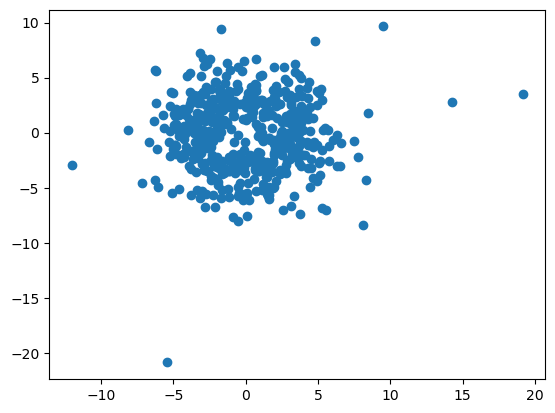

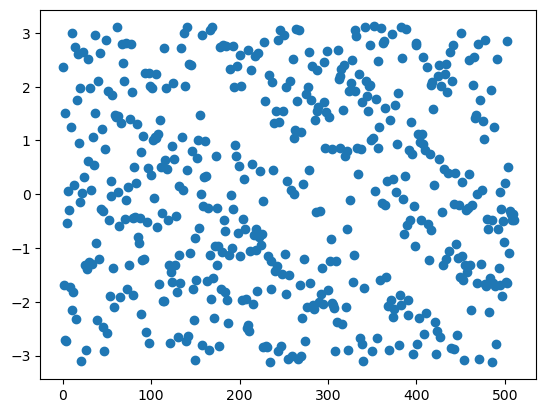

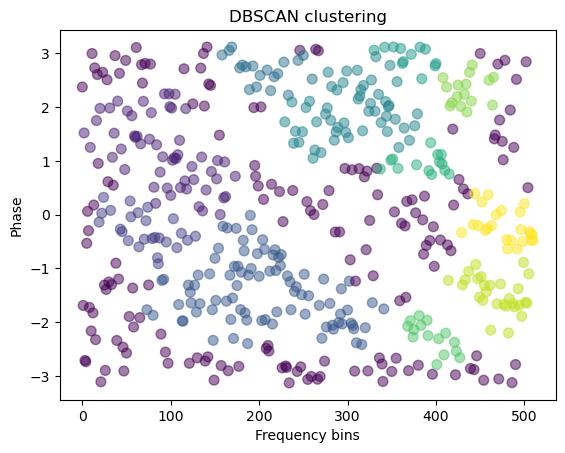

In [24]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import os
import warnings


# Set OMP_NUM_THREADS environment variable to 2
os.environ['OMP_NUM_THREADS'] = '2'
warnings.filterwarnings("ignore", category=UserWarning)

n = 1056
index = 120
Symbol_Two = y[Start_index + index*n :Start_index + (index+1)*n]
Symbol_Two = Symbol_Two[32:]
Symbol_Two = np.fft.fft(Symbol_Two, n = 1024)
Symbol_Two_correct = Symbol_Two / chanel_estimation
Symbol_Two_correct_2 = Symbol_Two / chanel_estimation_2

constelatons = np.loadtxt("constelations.txt", dtype=str)
# print(len(constelatons))
constelatons = constelatons[index*511:(index+1)*511]

index_1 = 0
index_2 = 511

plt.scatter(np.real(Symbol_Two_correct_2[index_1+1:index_2+1]), np.imag(Symbol_Two_correct_2[index_1+1:index_2+1]))
plt.show()

list_phase = [] # list of phase of all received data 
for x in range(index_1,index_2):
    phase = np.angle(Symbol_Two_correct_2[x+1])
    list_phase.append(phase)
frequency_bins = np.arange(index_1, index_2, 1).tolist()

plt.scatter(frequency_bins, list_phase)
plt.show()

# Reshape frequency_bins and list_phase for clustering
X = np.column_stack((frequency_bins, list_phase))
# Scale the features (frequency_bins and list_phase) to have mean=0 and variance=1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# eps: The maximum distance between two samples for one to be considered as in the neighborhood of the other
# min_samples: The number of samples (or total weight) in a neighborhood for a point to be considered as a core point
dbscan = DBSCAN(eps=0.29, min_samples=15)  # Adjust eps and min_samples as needed
labels = dbscan.fit_predict(X_scaled)

# Plot the data points colored according to the cluster they are assigned to
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50, alpha=0.5)
plt.xlabel('Frequency bins')
plt.ylabel('Phase')
plt.title('DBSCAN clustering')
plt.show()

Or we can plot the lines of the initial 4 clusters using kmeans then assign the points to the closest line, use that gradient info to estimate for the next gradient without using kmeans

In [52]:

from scipy import stats
import math
def phase_correction(past_centers, past_angle, current_OFDM):
    #print(past_phase.shape)
    corrected = current_OFDM
    corrected = corrected * np.exp(-1j * past_angle)
    centers = []
    d = []
    past_centers = np.asarray(past_centers)
    """cluster_1 = []
    cluster_2 = []
    cluster_3 = []
    cluster_4 = []"""
    labels = []
    inti = [[1, 1], [1, -1], [-1, -1], [-1, 1]]
    inti = np.array(inti)
    inti_complex = inti[:, 0] + 1j * inti[:, 1]
    if past_centers.shape[0] != 0:
        kmeans = KMeans(n_clusters=4, init=inti, random_state=0 ).fit(np.array([np.real(corrected), np.imag(corrected)]).T)
        centers = kmeans.cluster_centers_
        labels = kmeans.labels_
        complex_centers = centers[:, 0] + 1j * centers[:, 1]
        distance = complex_centers - inti_complex
        d = np.array(distance)
        angle = np.angle(d)
        angle = np.mean(angle)
        if angle < 0:
            angle = 2 * np.pi + angle
        corrected = corrected * np.exp(-1j * angle)
        past_angle += angle
    else:
        kmeans = KMeans(n_clusters=4, init=inti ).fit(np.array([np.real(corrected), np.imag(corrected)]).T)
        centers = kmeans.cluster_centers_
        labels = kmeans.labels_
        complex_centers = centers[:, 0] + 1j * centers[:, 1]

    return centers, past_angle, corrected

def gradient_correction(past_gradient, current_OFDM, known_value, positions):
    corrected = current_OFDM
    corrected = corrected * np.exp(-1j * past_gradient)
    known_angles = np.angle(known_value)
    check_angles = np.angle(corrected[positions])
    diff = np.unwrap(check_angles) - np.unwrap(known_angles)
    diff = np.unwrap(diff)
    mean_diff = np.mean(diff)
    grad, intercept, r_value, p_value, std_err = stats.linregress(positions, diff)
    if math.isclose(intercept, 2* np.pi, abs_tol=2):
        intercept = intercept - 2 * np.pi
    if math.isclose(intercept, -2* np.pi, abs_tol=2):
        intercept = intercept + 2 * np.pi


    gradient = grad * np.arange(len(current_OFDM)) + intercept

    if np.mean(np.abs(gradient)) > 1:
        gradient = 0
    final_corrected = corrected * np.exp(-1j * gradient)
    gradient = gradient + past_gradient
    return gradient, corrected, final_corrected, diff, grad, intercept

def combined_correction(past_centers, past_angle, past_gradient, current_OFDM):
    corrected = current_OFDM
    corrected = corrected * np.exp(-1j * past_gradient)
    corrected = corrected * np.exp(-1j * past_angle)
    centers = []
    d = []
    past_centers = np.asarray(past_centers)
    """cluster_1 = []
    cluster_2 = []
    cluster_3 = []
    cluster_4 = []"""
    labels = []
    inti = [[1, 1], [1, -1], [-1, -1], [-1, 1]]
    inti = np.array(inti)
    inti_complex = inti[:, 0] + 1j * inti[:, 1]
    if past_centers.shape[0] != 0:
        kmeans = KMeans(n_clusters=4, init=inti, random_state=0 ).fit(np.array([np.real(corrected), np.imag(corrected)]).T)
        centers = kmeans.cluster_centers_
        labels = kmeans.labels_
        complex_centers = centers[:, 0] + 1j * centers[:, 1]
        distance = complex_centers - inti_complex
        d = np.array(distance)
        angle = np.angle(d)
        for i in range(len(angle)):
            if angle[i] < 0:
                angle[i] = 2 * np.pi + angle[i]
        angle = np.mean(angle) - np.pi
        #print(angle)
        intermediate_corrected = corrected * np.exp(-1j * angle)
        """angle = np.mean(angle)
        if angle < 0:
            angle = 2 * np.pi + angle
        corrected = corrected * np.exp(-1j * angle)"""
        past_angle += angle
    else:
        kmeans = KMeans(n_clusters=4, init=inti ).fit(np.array([np.real(corrected), np.imag(corrected)]).T)
        centers = kmeans.cluster_centers_
        labels = kmeans.labels_
        complex_centers = centers[:, 0] + 1j * centers[:, 1]
        intermediate_corrected = corrected
    predicted_ideal_angle = []
    for i in range(len(labels)):
        predicted_ideal_angle.append(np.angle(complex_centers[labels[i]]))
    predicted_ideal_angle = np.array(predicted_ideal_angle)
    predicted_ideal_angle = np.unwrap(predicted_ideal_angle)
    known_angles = np.angle(corrected)
    known_angles = np.unwrap(known_angles)
    diff = known_angles - predicted_ideal_angle
    diff = np.unwrap(diff)
    positions = np.arange(len(corrected)) + 1
    grad, intercept, r_value, p_value, std_err = stats.linregress(positions, diff)
    if math.isclose(intercept, 2* np.pi, abs_tol=2):
        intercept = intercept - 2 * np.pi
    if math.isclose(intercept, -2* np.pi, abs_tol=2):
        intercept = intercept + 2 * np.pi

    gradient = grad * np.arange(len(current_OFDM)) + intercept

    if np.mean(np.abs(gradient)) > 0.3:
        gradient = 0
    final_corrected = corrected * np.exp(-1j * gradient)
    gradient = gradient + past_gradient

    return centers, past_angle, gradient, corrected, intermediate_corrected, final_corrected, diff, intercept, grad
    
    

[ -1.05075398  -1.07609195  -1.10142992  -1.12676789  -1.15210586
  -1.17744383  -1.2027818   -1.22811977  -1.25345774  -1.27879571
  -1.30413368  -1.32947165  -1.35480962  -1.38014759  -1.40548556
  -1.43082353  -1.4561615   -1.48149947  -1.50683744  -1.53217541
  -1.55751338  -1.58285135  -1.60818932  -1.63352729  -1.65886525
  -1.68420322  -1.70954119  -1.73487916  -1.76021713  -1.7855551
  -1.81089307  -1.83623104  -1.86156901  -1.88690698  -1.91224495
  -1.93758292  -1.96292089  -1.98825886  -2.01359683  -2.0389348
  -2.06427277  -2.08961074  -2.11494871  -2.14028668  -2.16562465
  -2.19096262  -2.21630059  -2.24163856  -2.26697653  -2.2923145
  -2.31765247  -2.34299044  -2.36832841  -2.39366638  -2.41900435
  -2.44434232  -2.46968029  -2.49501826  -2.52035623  -2.5456942
  -2.57103217  -2.59637014  -2.62170811  -2.64704608  -2.67238405
  -2.69772202  -2.72305999  -2.74839796  -2.77373593  -2.7990739
  -2.82441187  -2.84974984  -2.87508781  -2.90042578  -2.92576375
  -2.95110172  

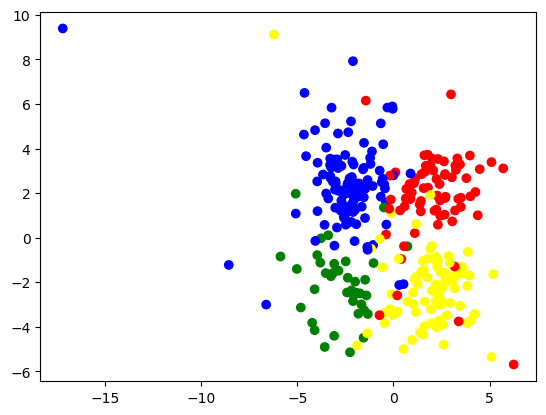

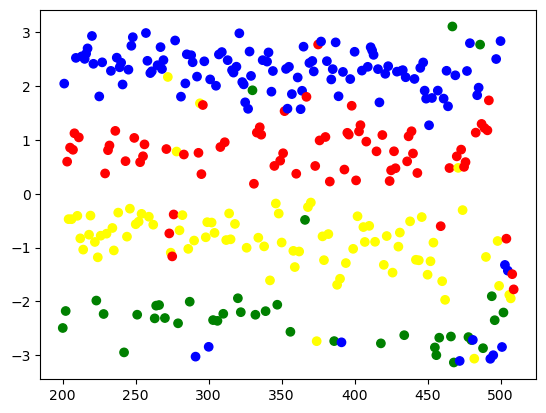

[ -0.81006925  -0.83617956  -0.86228987  -0.88840018  -0.91451049
  -0.9406208   -0.96673111  -0.99284142  -1.01895173  -1.04506204
  -1.07117235  -1.09728266  -1.12339297  -1.14950328  -1.17561359
  -1.2017239   -1.22783421  -1.25394452  -1.28005483  -1.30616514
  -1.33227545  -1.35838576  -1.38449607  -1.41060638  -1.43671669
  -1.462827    -1.4889373   -1.51504761  -1.54115792  -1.56726823
  -1.59337854  -1.61948885  -1.64559916  -1.67170947  -1.69781978
  -1.72393009  -1.7500404   -1.77615071  -1.80226102  -1.82837133
  -1.85448164  -1.88059195  -1.90670226  -1.93281257  -1.95892288
  -1.98503319  -2.0111435   -2.03725381  -2.06336412  -2.08947443
  -2.11558474  -2.14169505  -2.16780535  -2.19391566  -2.22002597
  -2.24613628  -2.27224659  -2.2983569   -2.32446721  -2.35057752
  -2.37668783  -2.40279814  -2.42890845  -2.45501876  -2.48112907
  -2.50723938  -2.53334969  -2.55946     -2.58557031  -2.61168062
  -2.63779093  -2.66390124  -2.69001155  -2.71612186  -2.74223217
  -2.76834

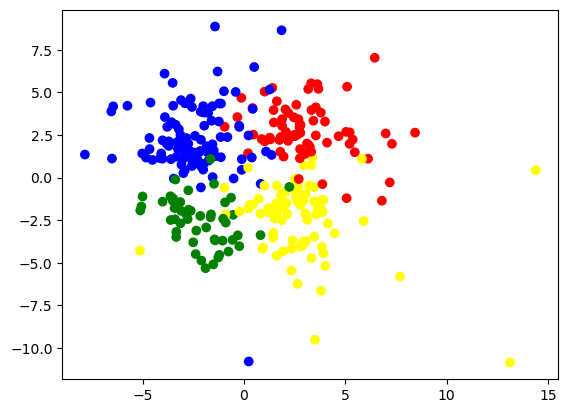

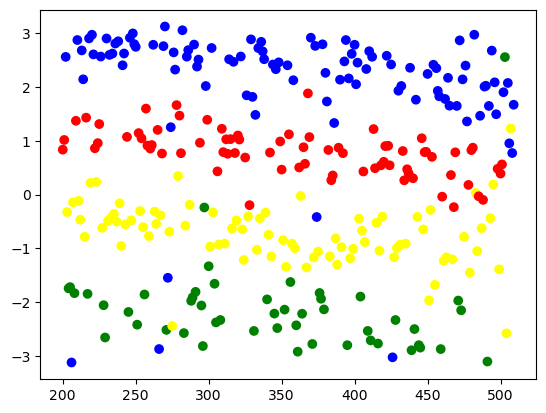

[ -0.18138574  -0.20902265  -0.23665957  -0.26429648  -0.29193339
  -0.3195703   -0.34720721  -0.37484412  -0.40248103  -0.43011794
  -0.45775486  -0.48539177  -0.51302868  -0.54066559  -0.5683025
  -0.59593941  -0.62357632  -0.65121323  -0.67885015  -0.70648706
  -0.73412397  -0.76176088  -0.78939779  -0.8170347   -0.84467161
  -0.87230852  -0.89994544  -0.92758235  -0.95521926  -0.98285617
  -1.01049308  -1.03812999  -1.0657669   -1.09340381  -1.12104073
  -1.14867764  -1.17631455  -1.20395146  -1.23158837  -1.25922528
  -1.28686219  -1.3144991   -1.34213602  -1.36977293  -1.39740984
  -1.42504675  -1.45268366  -1.48032057  -1.50795748  -1.53559439
  -1.56323131  -1.59086822  -1.61850513  -1.64614204  -1.67377895
  -1.70141586  -1.72905277  -1.75668968  -1.7843266   -1.81196351
  -1.83960042  -1.86723733  -1.89487424  -1.92251115  -1.95014806
  -1.97778497  -2.00542189  -2.0330588   -2.06069571  -2.08833262
  -2.11596953  -2.14360644  -2.17124335  -2.19888026  -2.22651718
  -2.254154

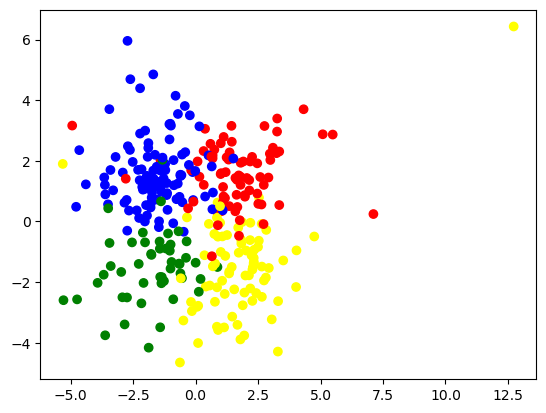

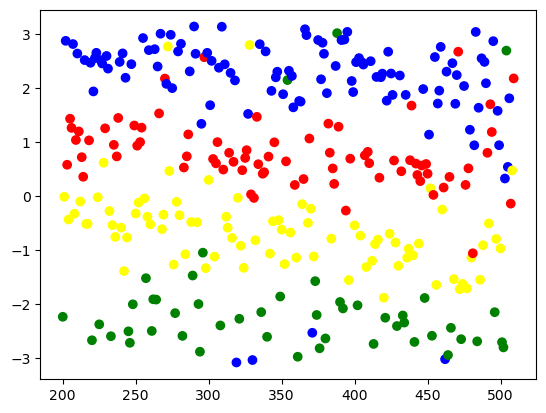

[ 1.35151912e-01  1.06539500e-01  7.79270889e-02  4.93146775e-02
  2.07022660e-02 -7.91014542e-03 -3.65225569e-02 -6.51349683e-02
 -9.37473798e-02 -1.22359791e-01 -1.50972203e-01 -1.79584614e-01
 -2.08197026e-01 -2.36809437e-01 -2.65421849e-01 -2.94034260e-01
 -3.22646671e-01 -3.51259083e-01 -3.79871494e-01 -4.08483906e-01
 -4.37096317e-01 -4.65708729e-01 -4.94321140e-01 -5.22933552e-01
 -5.51545963e-01 -5.80158375e-01 -6.08770786e-01 -6.37383197e-01
 -6.65995609e-01 -6.94608020e-01 -7.23220432e-01 -7.51832843e-01
 -7.80445255e-01 -8.09057666e-01 -8.37670078e-01 -8.66282489e-01
 -8.94894901e-01 -9.23507312e-01 -9.52119723e-01 -9.80732135e-01
 -1.00934455e+00 -1.03795696e+00 -1.06656937e+00 -1.09518178e+00
 -1.12379419e+00 -1.15240660e+00 -1.18101902e+00 -1.20963143e+00
 -1.23824384e+00 -1.26685625e+00 -1.29546866e+00 -1.32408107e+00
 -1.35269348e+00 -1.38130590e+00 -1.40991831e+00 -1.43853072e+00
 -1.46714313e+00 -1.49575554e+00 -1.52436795e+00 -1.55298036e+00
 -1.58159278e+00 -1.61020

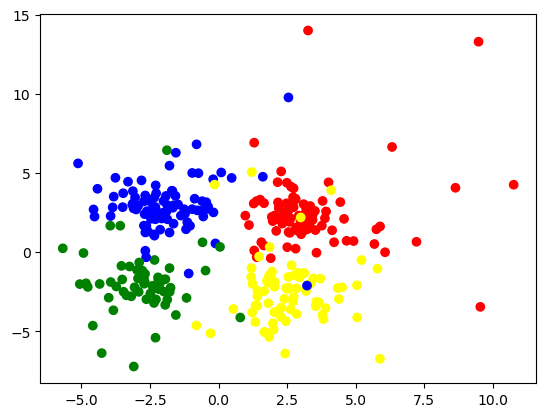

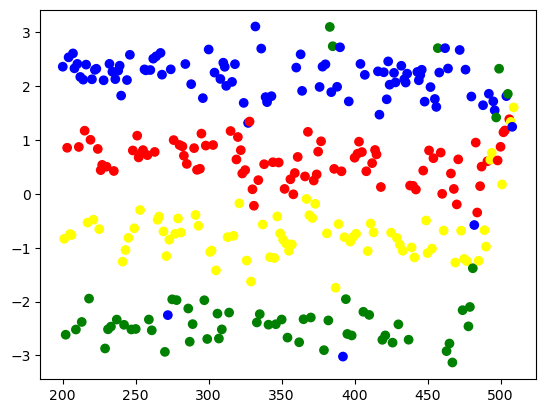

[ 1.13811243e-01  8.53353138e-02  5.68593850e-02  2.83834563e-02
 -9.24724784e-05 -2.85684012e-02 -5.70443300e-02 -8.55202587e-02
 -1.13996187e-01 -1.42472116e-01 -1.70948045e-01 -1.99423974e-01
 -2.27899902e-01 -2.56375831e-01 -2.84851760e-01 -3.13327689e-01
 -3.41803617e-01 -3.70279546e-01 -3.98755475e-01 -4.27231404e-01
 -4.55707332e-01 -4.84183261e-01 -5.12659190e-01 -5.41135119e-01
 -5.69611047e-01 -5.98086976e-01 -6.26562905e-01 -6.55038834e-01
 -6.83514762e-01 -7.11990691e-01 -7.40466620e-01 -7.68942549e-01
 -7.97418477e-01 -8.25894406e-01 -8.54370335e-01 -8.82846264e-01
 -9.11322192e-01 -9.39798121e-01 -9.68274050e-01 -9.96749979e-01
 -1.02522591e+00 -1.05370184e+00 -1.08217776e+00 -1.11065369e+00
 -1.13912962e+00 -1.16760555e+00 -1.19608148e+00 -1.22455741e+00
 -1.25303334e+00 -1.28150927e+00 -1.30998519e+00 -1.33846112e+00
 -1.36693705e+00 -1.39541298e+00 -1.42388891e+00 -1.45236484e+00
 -1.48084077e+00 -1.50931670e+00 -1.53779262e+00 -1.56626855e+00
 -1.59474448e+00 -1.62322

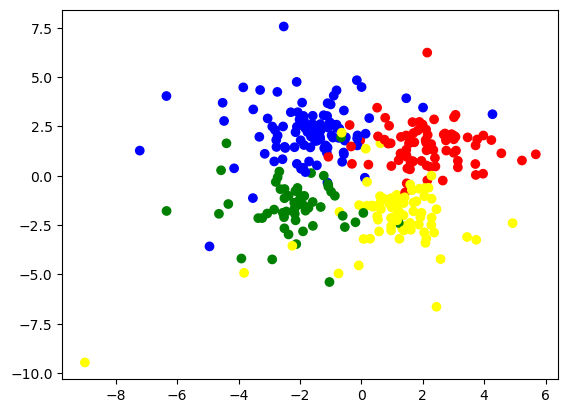

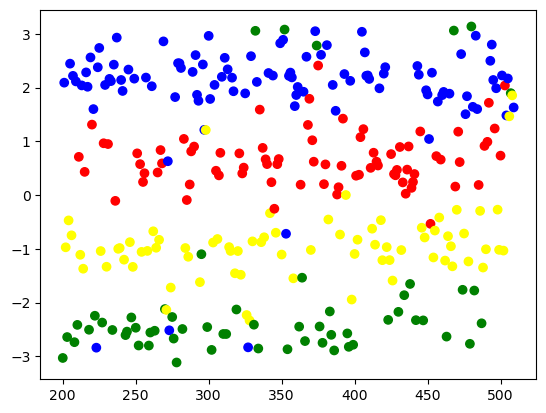

[ -0.30266608  -0.33090181  -0.35913753  -0.38737325  -0.41560898
  -0.4438447   -0.47208042  -0.50031615  -0.52855187  -0.55678759
  -0.58502332  -0.61325904  -0.64149476  -0.66973049  -0.69796621
  -0.72620193  -0.75443766  -0.78267338  -0.81090911  -0.83914483
  -0.86738055  -0.89561628  -0.923852    -0.95208772  -0.98032345
  -1.00855917  -1.03679489  -1.06503062  -1.09326634  -1.12150206
  -1.14973779  -1.17797351  -1.20620923  -1.23444496  -1.26268068
  -1.2909164   -1.31915213  -1.34738785  -1.37562357  -1.4038593
  -1.43209502  -1.46033075  -1.48856647  -1.51680219  -1.54503792
  -1.57327364  -1.60150936  -1.62974509  -1.65798081  -1.68621653
  -1.71445226  -1.74268798  -1.7709237   -1.79915943  -1.82739515
  -1.85563087  -1.8838666   -1.91210232  -1.94033804  -1.96857377
  -1.99680949  -2.02504522  -2.05328094  -2.08151666  -2.10975239
  -2.13798811  -2.16622383  -2.19445956  -2.22269528  -2.250931
  -2.27916673  -2.30740245  -2.33563817  -2.3638739   -2.39210962
  -2.42034534

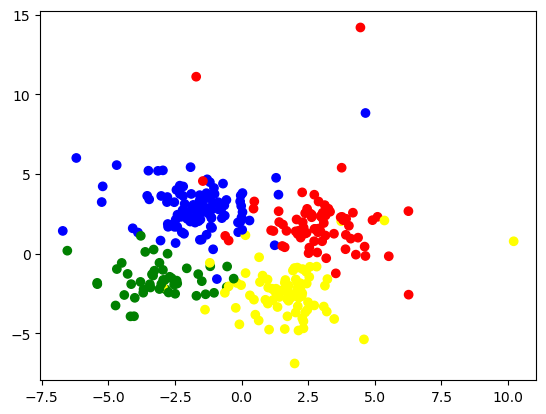

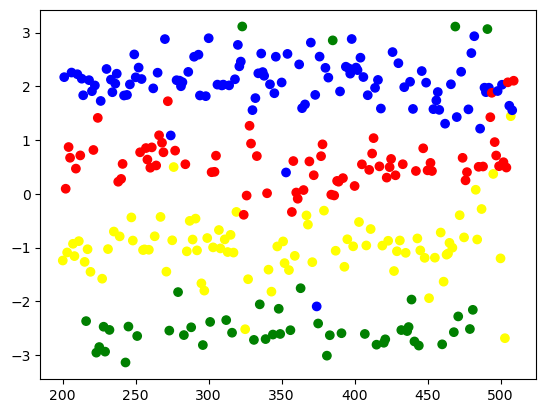

[ 3.16138945e-01  2.86085543e-01  2.56032140e-01  2.25978738e-01
  1.95925335e-01  1.65871933e-01  1.35818530e-01  1.05765128e-01
  7.57117253e-02  4.56583228e-02  1.56049203e-02 -1.44484822e-02
 -4.45018847e-02 -7.45552872e-02 -1.04608690e-01 -1.34662092e-01
 -1.64715495e-01 -1.94768897e-01 -2.24822300e-01 -2.54875702e-01
 -2.84929105e-01 -3.14982507e-01 -3.45035910e-01 -3.75089312e-01
 -4.05142715e-01 -4.35196117e-01 -4.65249520e-01 -4.95302922e-01
 -5.25356325e-01 -5.55409727e-01 -5.85463130e-01 -6.15516532e-01
 -6.45569935e-01 -6.75623337e-01 -7.05676740e-01 -7.35730142e-01
 -7.65783545e-01 -7.95836947e-01 -8.25890350e-01 -8.55943752e-01
 -8.85997155e-01 -9.16050557e-01 -9.46103960e-01 -9.76157362e-01
 -1.00621076e+00 -1.03626417e+00 -1.06631757e+00 -1.09637097e+00
 -1.12642437e+00 -1.15647778e+00 -1.18653118e+00 -1.21658458e+00
 -1.24663798e+00 -1.27669139e+00 -1.30674479e+00 -1.33679819e+00
 -1.36685159e+00 -1.39690500e+00 -1.42695840e+00 -1.45701180e+00
 -1.48706520e+00 -1.51711

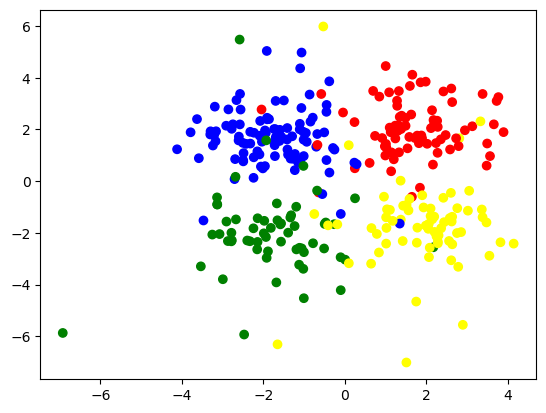

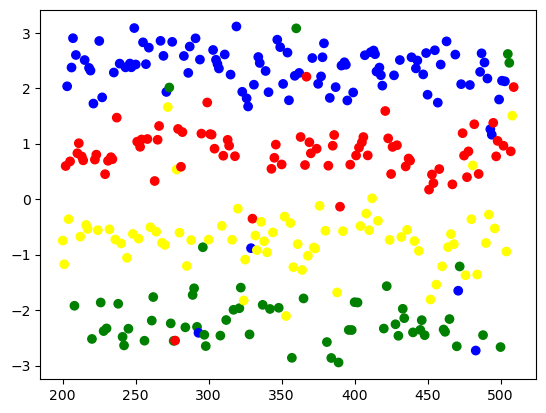

[ -0.65136167  -0.67877399  -0.70618631  -0.73359863  -0.76101095
  -0.78842327  -0.81583559  -0.84324791  -0.87066023  -0.89807255
  -0.92548487  -0.95289719  -0.98030951  -1.00772183  -1.03513415
  -1.06254647  -1.08995879  -1.11737111  -1.14478343  -1.17219575
  -1.19960807  -1.22702039  -1.25443271  -1.28184503  -1.30925735
  -1.33666967  -1.36408199  -1.39149431  -1.41890663  -1.44631895
  -1.47373127  -1.50114359  -1.52855591  -1.55596823  -1.58338055
  -1.61079287  -1.63820519  -1.66561751  -1.69302983  -1.72044215
  -1.74785447  -1.77526679  -1.80267911  -1.83009143  -1.85750375
  -1.88491607  -1.91232839  -1.93974071  -1.96715303  -1.99456535
  -2.02197767  -2.04938999  -2.07680231  -2.10421463  -2.13162695
  -2.15903927  -2.18645159  -2.21386391  -2.24127623  -2.26868855
  -2.29610087  -2.32351319  -2.35092551  -2.37833783  -2.40575015
  -2.43316247  -2.46057479  -2.48798711  -2.51539942  -2.54281174
  -2.57022406  -2.59763638  -2.6250487   -2.65246102  -2.67987334
  -2.70728

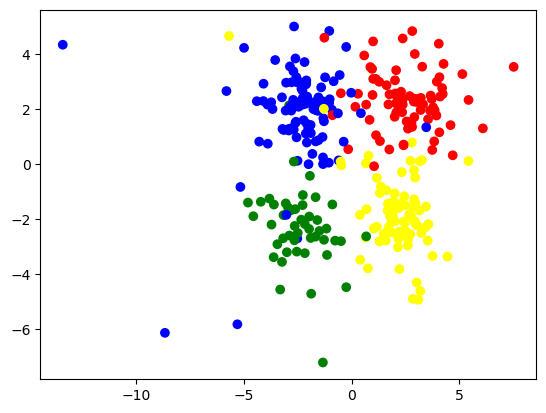

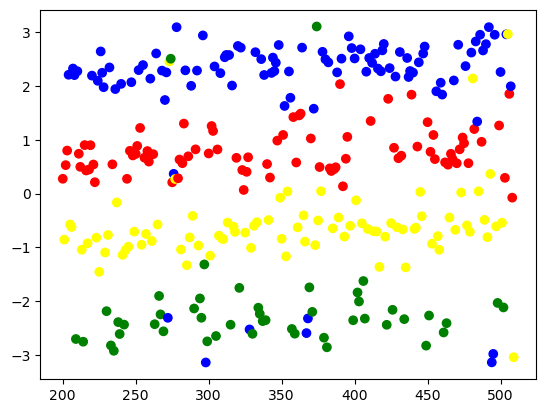

[ 8.58351838e-01  8.27329244e-01  7.96306650e-01  7.65284056e-01
  7.34261461e-01  7.03238867e-01  6.72216273e-01  6.41193679e-01
  6.10171085e-01  5.79148490e-01  5.48125896e-01  5.17103302e-01
  4.86080708e-01  4.55058114e-01  4.24035520e-01  3.93012925e-01
  3.61990331e-01  3.30967737e-01  2.99945143e-01  2.68922549e-01
  2.37899954e-01  2.06877360e-01  1.75854766e-01  1.44832172e-01
  1.13809578e-01  8.27869835e-02  5.17643893e-02  2.07417951e-02
 -1.02807991e-02 -4.13033933e-02 -7.23259875e-02 -1.03348582e-01
 -1.34371176e-01 -1.65393770e-01 -1.96416364e-01 -2.27438958e-01
 -2.58461553e-01 -2.89484147e-01 -3.20506741e-01 -3.51529335e-01
 -3.82551929e-01 -4.13574524e-01 -4.44597118e-01 -4.75619712e-01
 -5.06642306e-01 -5.37664900e-01 -5.68687494e-01 -5.99710089e-01
 -6.30732683e-01 -6.61755277e-01 -6.92777871e-01 -7.23800465e-01
 -7.54823060e-01 -7.85845654e-01 -8.16868248e-01 -8.47890842e-01
 -8.78913436e-01 -9.09936031e-01 -9.40958625e-01 -9.71981219e-01
 -1.00300381e+00 -1.03402

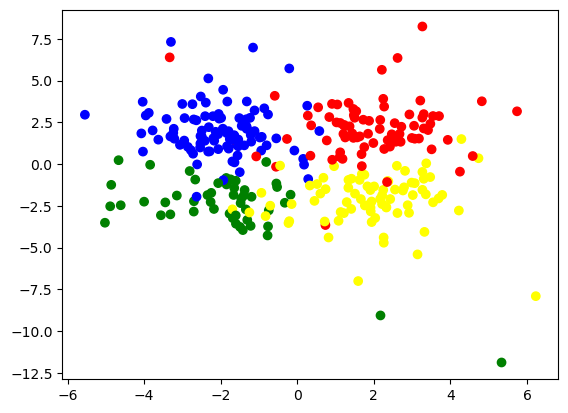

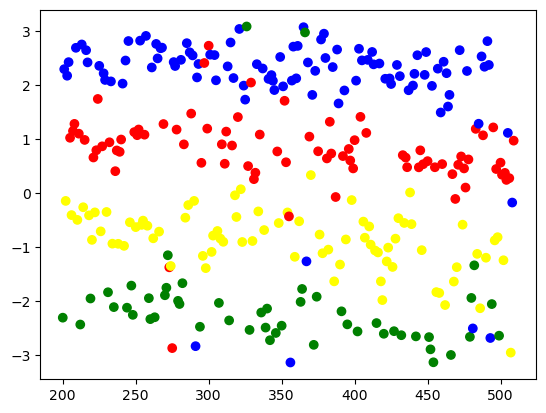

[ 4.57831844e-01  4.27299494e-01  3.96767145e-01  3.66234796e-01
  3.35702446e-01  3.05170097e-01  2.74637747e-01  2.44105398e-01
  2.13573048e-01  1.83040699e-01  1.52508349e-01  1.21976000e-01
  9.14436501e-02  6.09113006e-02  3.03789511e-02 -1.53398345e-04
 -3.06857478e-02 -6.12180973e-02 -9.17504468e-02 -1.22282796e-01
 -1.52815146e-01 -1.83347495e-01 -2.13879845e-01 -2.44412194e-01
 -2.74944544e-01 -3.05476893e-01 -3.36009243e-01 -3.66541592e-01
 -3.97073942e-01 -4.27606291e-01 -4.58138641e-01 -4.88670990e-01
 -5.19203340e-01 -5.49735689e-01 -5.80268039e-01 -6.10800388e-01
 -6.41332738e-01 -6.71865087e-01 -7.02397437e-01 -7.32929786e-01
 -7.63462136e-01 -7.93994485e-01 -8.24526835e-01 -8.55059184e-01
 -8.85591533e-01 -9.16123883e-01 -9.46656232e-01 -9.77188582e-01
 -1.00772093e+00 -1.03825328e+00 -1.06878563e+00 -1.09931798e+00
 -1.12985033e+00 -1.16038268e+00 -1.19091503e+00 -1.22144738e+00
 -1.25197973e+00 -1.28251208e+00 -1.31304443e+00 -1.34357678e+00
 -1.37410913e+00 -1.40464

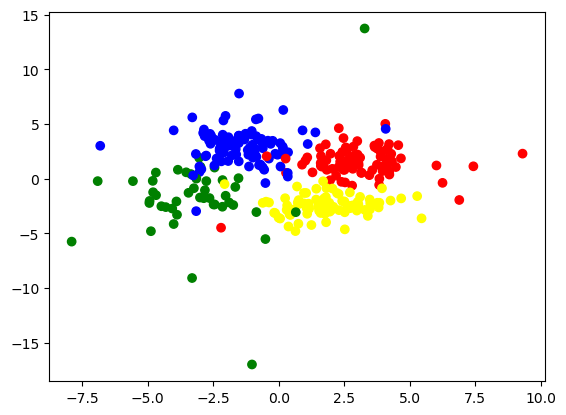

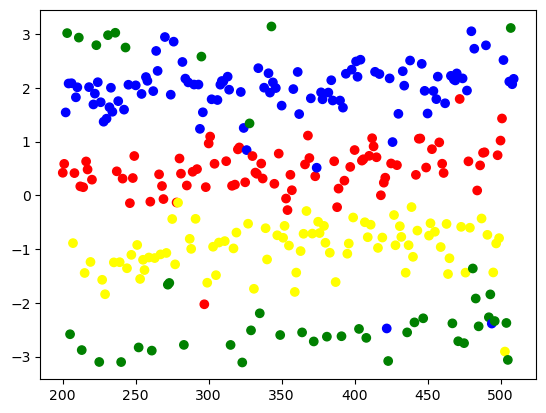

[ -0.13866461  -0.16825285  -0.19784108  -0.22742931  -0.25701754
  -0.28660577  -0.31619401  -0.34578224  -0.37537047  -0.4049587
  -0.43454694  -0.46413517  -0.4937234   -0.52331163  -0.55289986
  -0.5824881   -0.61207633  -0.64166456  -0.67125279  -0.70084103
  -0.73042926  -0.76001749  -0.78960572  -0.81919395  -0.84878219
  -0.87837042  -0.90795865  -0.93754688  -0.96713512  -0.99672335
  -1.02631158  -1.05589981  -1.08548804  -1.11507628  -1.14466451
  -1.17425274  -1.20384097  -1.23342921  -1.26301744  -1.29260567
  -1.3221939   -1.35178213  -1.38137037  -1.4109586   -1.44054683
  -1.47013506  -1.49972329  -1.52931153  -1.55889976  -1.58848799
  -1.61807622  -1.64766446  -1.67725269  -1.70684092  -1.73642915
  -1.76601738  -1.79560562  -1.82519385  -1.85478208  -1.88437031
  -1.91395855  -1.94354678  -1.97313501  -2.00272324  -2.03231147
  -2.06189971  -2.09148794  -2.12107617  -2.1506644   -2.18025264
  -2.20984087  -2.2394291   -2.26901733  -2.29860556  -2.3281938
  -2.3577820

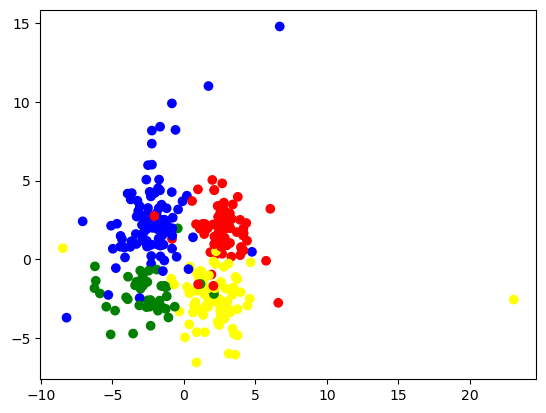

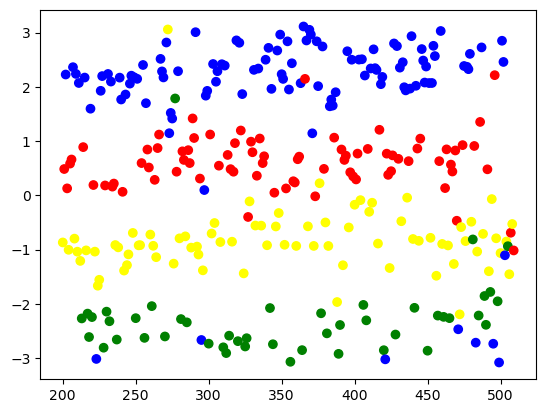

[ 3.31242938e-01  3.00762519e-01  2.70282101e-01  2.39801682e-01
  2.09321263e-01  1.78840844e-01  1.48360425e-01  1.17880006e-01
  8.73995874e-02  5.69191685e-02  2.64387497e-02 -4.04166919e-03
 -3.45220880e-02 -6.50025069e-02 -9.54829258e-02 -1.25963345e-01
 -1.56443763e-01 -1.86924182e-01 -2.17404601e-01 -2.47885020e-01
 -2.78365439e-01 -3.08845858e-01 -3.39326277e-01 -3.69806695e-01
 -4.00287114e-01 -4.30767533e-01 -4.61247952e-01 -4.91728371e-01
 -5.22208790e-01 -5.52689209e-01 -5.83169628e-01 -6.13650046e-01
 -6.44130465e-01 -6.74610884e-01 -7.05091303e-01 -7.35571722e-01
 -7.66052141e-01 -7.96532560e-01 -8.27012978e-01 -8.57493397e-01
 -8.87973816e-01 -9.18454235e-01 -9.48934654e-01 -9.79415073e-01
 -1.00989549e+00 -1.04037591e+00 -1.07085633e+00 -1.10133675e+00
 -1.13181717e+00 -1.16229759e+00 -1.19277800e+00 -1.22325842e+00
 -1.25373884e+00 -1.28421926e+00 -1.31469968e+00 -1.34518010e+00
 -1.37566052e+00 -1.40614094e+00 -1.43662136e+00 -1.46710177e+00
 -1.49758219e+00 -1.52806

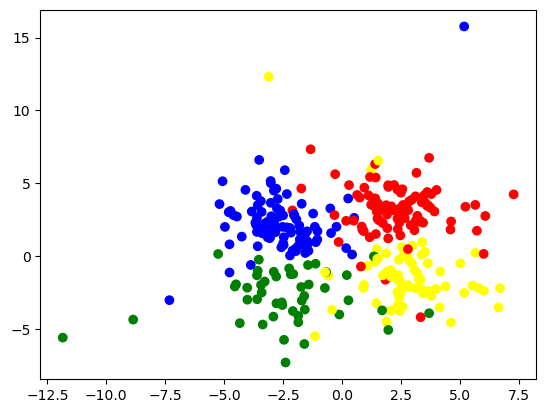

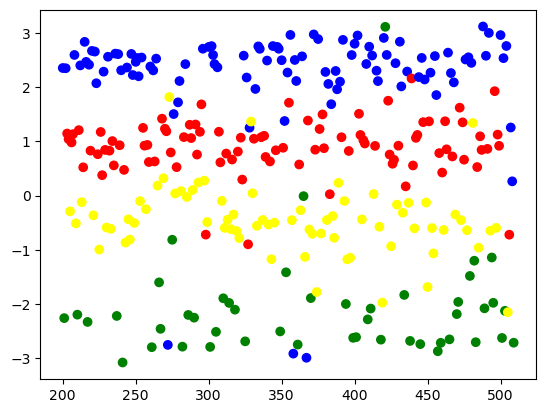

[ -1.34600459  -1.37245636  -1.39890814  -1.42535992  -1.4518117
  -1.47826347  -1.50471525  -1.53116703  -1.55761881  -1.58407058
  -1.61052236  -1.63697414  -1.66342591  -1.68987769  -1.71632947
  -1.74278125  -1.76923302  -1.7956848   -1.82213658  -1.84858836
  -1.87504013  -1.90149191  -1.92794369  -1.95439547  -1.98084724
  -2.00729902  -2.0337508   -2.06020257  -2.08665435  -2.11310613
  -2.13955791  -2.16600968  -2.19246146  -2.21891324  -2.24536502
  -2.27181679  -2.29826857  -2.32472035  -2.35117213  -2.3776239
  -2.40407568  -2.43052746  -2.45697923  -2.48343101  -2.50988279
  -2.53633457  -2.56278634  -2.58923812  -2.6156899   -2.64214168
  -2.66859345  -2.69504523  -2.72149701  -2.74794878  -2.77440056
  -2.80085234  -2.82730412  -2.85375589  -2.88020767  -2.90665945
  -2.93311123  -2.959563    -2.98601478  -3.01246656  -3.03891834
  -3.06537011  -3.09182189  -3.11827367  -3.14472544  -3.17117722
  -3.197629    -3.22408078  -3.25053255  -3.27698433  -3.30343611
  -3.3298878

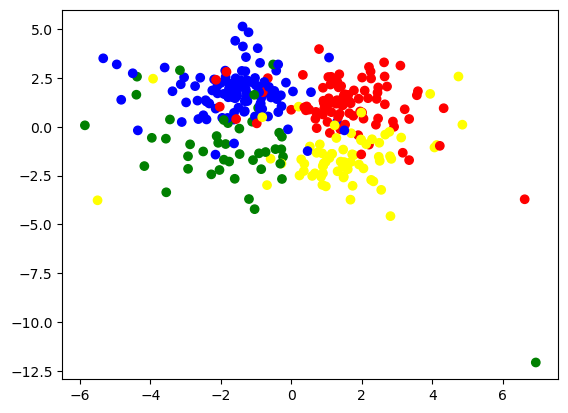

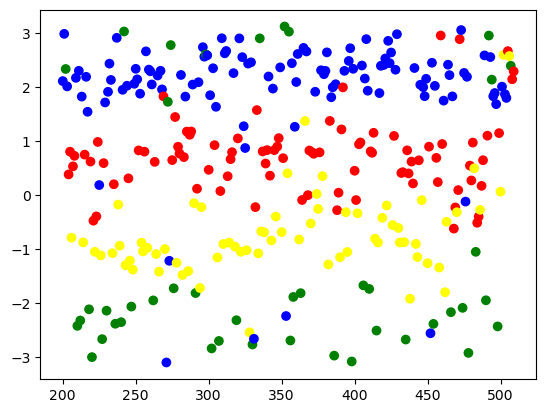

[ -0.46413831  -0.49264211  -0.52114591  -0.54964971  -0.57815351
  -0.60665732  -0.63516112  -0.66366492  -0.69216872  -0.72067252
  -0.74917632  -0.77768012  -0.80618392  -0.83468772  -0.86319153
  -0.89169533  -0.92019913  -0.94870293  -0.97720673  -1.00571053
  -1.03421433  -1.06271813  -1.09122193  -1.11972574  -1.14822954
  -1.17673334  -1.20523714  -1.23374094  -1.26224474  -1.29074854
  -1.31925234  -1.34775615  -1.37625995  -1.40476375  -1.43326755
  -1.46177135  -1.49027515  -1.51877895  -1.54728275  -1.57578655
  -1.60429036  -1.63279416  -1.66129796  -1.68980176  -1.71830556
  -1.74680936  -1.77531316  -1.80381696  -1.83232076  -1.86082457
  -1.88932837  -1.91783217  -1.94633597  -1.97483977  -2.00334357
  -2.03184737  -2.06035117  -2.08885498  -2.11735878  -2.14586258
  -2.17436638  -2.20287018  -2.23137398  -2.25987778  -2.28838158
  -2.31688538  -2.34538919  -2.37389299  -2.40239679  -2.43090059
  -2.45940439  -2.48790819  -2.51641199  -2.54491579  -2.57341959
  -2.60192

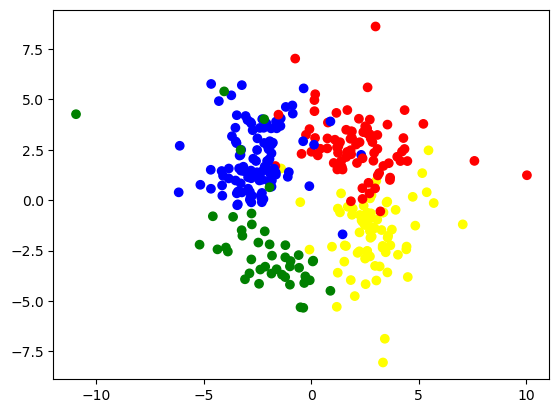

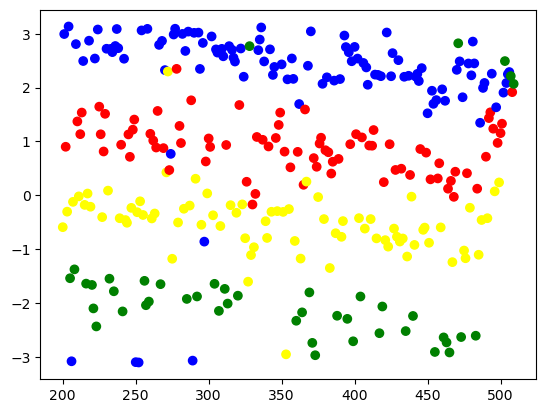

[ -0.59687092  -0.62576165  -0.65465239  -0.68354313  -0.71243386
  -0.7413246   -0.77021534  -0.79910608  -0.82799681  -0.85688755
  -0.88577829  -0.91466902  -0.94355976  -0.9724505   -1.00134123
  -1.03023197  -1.05912271  -1.08801344  -1.11690418  -1.14579492
  -1.17468566  -1.20357639  -1.23246713  -1.26135787  -1.2902486
  -1.31913934  -1.34803008  -1.37692081  -1.40581155  -1.43470229
  -1.46359302  -1.49248376  -1.5213745   -1.55026523  -1.57915597
  -1.60804671  -1.63693745  -1.66582818  -1.69471892  -1.72360966
  -1.75250039  -1.78139113  -1.81028187  -1.8391726   -1.86806334
  -1.89695408  -1.92584481  -1.95473555  -1.98362629  -2.01251703
  -2.04140776  -2.0702985   -2.09918924  -2.12807997  -2.15697071
  -2.18586145  -2.21475218  -2.24364292  -2.27253366  -2.30142439
  -2.33031513  -2.35920587  -2.38809661  -2.41698734  -2.44587808
  -2.47476882  -2.50365955  -2.53255029  -2.56144103  -2.59033176
  -2.6192225   -2.64811324  -2.67700397  -2.70589471  -2.73478545
  -2.763676

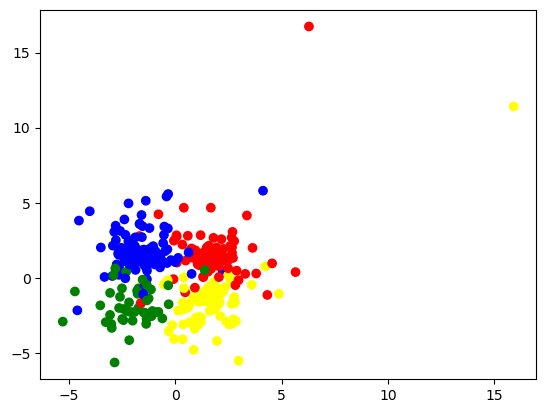

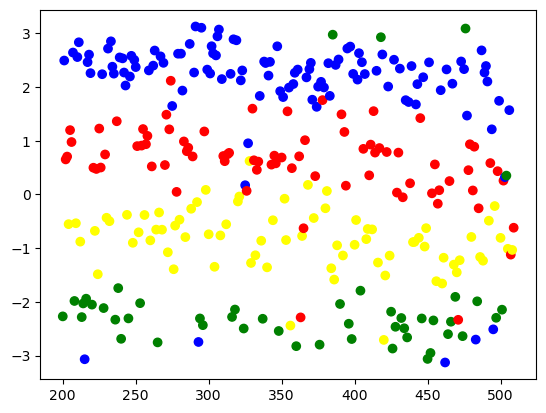

[ -0.28542092  -0.31485785  -0.34429477  -0.3737317   -0.40316862
  -0.43260555  -0.46204247  -0.4914794   -0.52091633  -0.55035325
  -0.57979018  -0.6092271   -0.63866403  -0.66810095  -0.69753788
  -0.7269748   -0.75641173  -0.78584866  -0.81528558  -0.84472251
  -0.87415943  -0.90359636  -0.93303328  -0.96247021  -0.99190713
  -1.02134406  -1.05078098  -1.08021791  -1.10965484  -1.13909176
  -1.16852869  -1.19796561  -1.22740254  -1.25683946  -1.28627639
  -1.31571331  -1.34515024  -1.37458717  -1.40402409  -1.43346102
  -1.46289794  -1.49233487  -1.52177179  -1.55120872  -1.58064564
  -1.61008257  -1.6395195   -1.66895642  -1.69839335  -1.72783027
  -1.7572672   -1.78670412  -1.81614105  -1.84557797  -1.8750149
  -1.90445183  -1.93388875  -1.96332568  -1.9927626   -2.02219953
  -2.05163645  -2.08107338  -2.1105103   -2.13994723  -2.16938416
  -2.19882108  -2.22825801  -2.25769493  -2.28713186  -2.31656878
  -2.34600571  -2.37544263  -2.40487956  -2.43431648  -2.46375341
  -2.493190

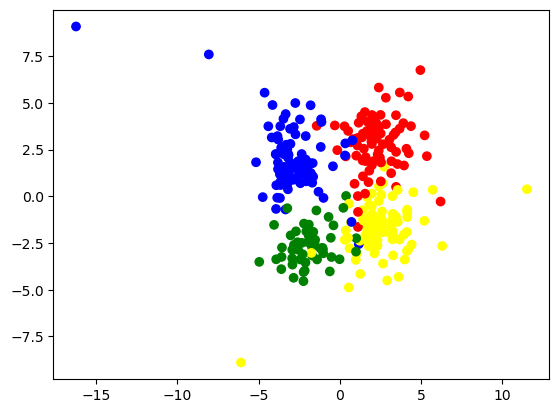

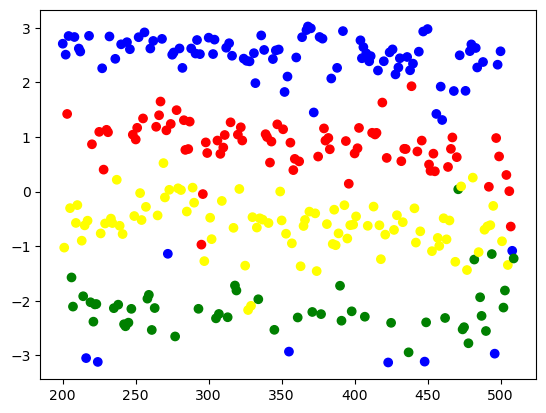

[ -1.02984258  -1.05844095  -1.08703931  -1.11563768  -1.14423605
  -1.17283442  -1.20143279  -1.23003115  -1.25862952  -1.28722789
  -1.31582626  -1.34442462  -1.37302299  -1.40162136  -1.43021973
  -1.45881809  -1.48741646  -1.51601483  -1.5446132   -1.57321156
  -1.60180993  -1.6304083   -1.65900667  -1.68760503  -1.7162034
  -1.74480177  -1.77340014  -1.80199851  -1.83059687  -1.85919524
  -1.88779361  -1.91639198  -1.94499034  -1.97358871  -2.00218708
  -2.03078545  -2.05938381  -2.08798218  -2.11658055  -2.14517892
  -2.17377728  -2.20237565  -2.23097402  -2.25957239  -2.28817075
  -2.31676912  -2.34536749  -2.37396586  -2.40256423  -2.43116259
  -2.45976096  -2.48835933  -2.5169577   -2.54555606  -2.57415443
  -2.6027528   -2.63135117  -2.65994953  -2.6885479   -2.71714627
  -2.74574464  -2.774343    -2.80294137  -2.83153974  -2.86013811
  -2.88873647  -2.91733484  -2.94593321  -2.97453158  -3.00312995
  -3.03172831  -3.06032668  -3.08892505  -3.11752342  -3.14612178
  -3.174720

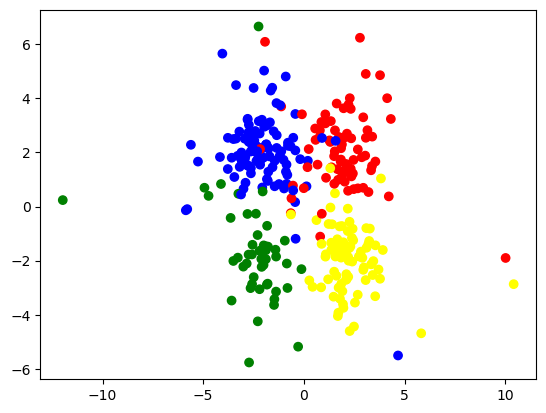

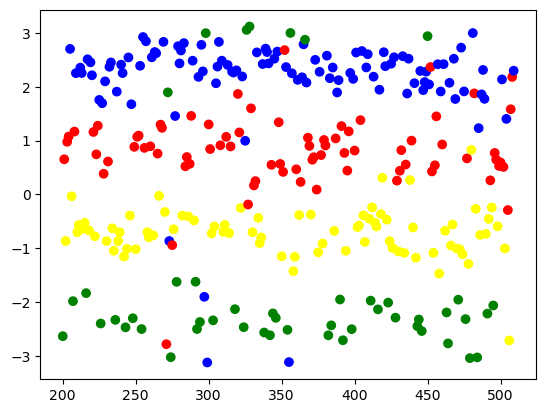

[ -1.04864423  -1.07613782  -1.1036314   -1.13112499  -1.15861858
  -1.18611217  -1.21360576  -1.24109934  -1.26859293  -1.29608652
  -1.32358011  -1.3510737   -1.37856728  -1.40606087  -1.43355446
  -1.46104805  -1.48854163  -1.51603522  -1.54352881  -1.5710224
  -1.59851599  -1.62600957  -1.65350316  -1.68099675  -1.70849034
  -1.73598393  -1.76347751  -1.7909711   -1.81846469  -1.84595828
  -1.87345187  -1.90094545  -1.92843904  -1.95593263  -1.98342622
  -2.0109198   -2.03841339  -2.06590698  -2.09340057  -2.12089416
  -2.14838774  -2.17588133  -2.20337492  -2.23086851  -2.2583621
  -2.28585568  -2.31334927  -2.34084286  -2.36833645  -2.39583004
  -2.42332362  -2.45081721  -2.4783108   -2.50580439  -2.53329797
  -2.56079156  -2.58828515  -2.61577874  -2.64327233  -2.67076591
  -2.6982595   -2.72575309  -2.75324668  -2.78074027  -2.80823385
  -2.83572744  -2.86322103  -2.89071462  -2.91820821  -2.94570179
  -2.97319538  -3.00068897  -3.02818256  -3.05567614  -3.08316973
  -3.1106633

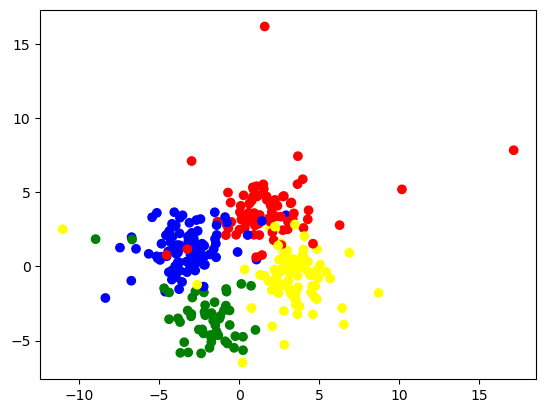

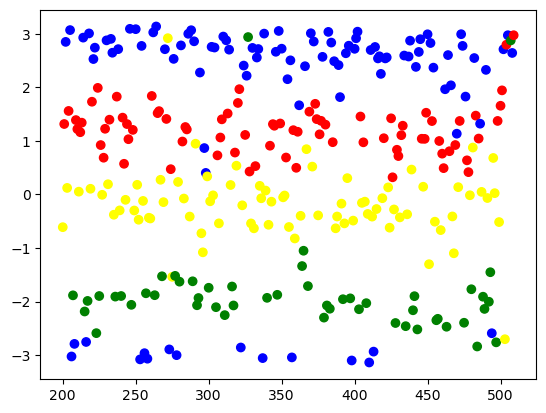

[ -0.11545378  -0.14577882  -0.17610386  -0.20642889  -0.23675393
  -0.26707896  -0.297404    -0.32772904  -0.35805407  -0.38837911
  -0.41870415  -0.44902918  -0.47935422  -0.50967925  -0.54000429
  -0.57032933  -0.60065436  -0.6309794   -0.66130443  -0.69162947
  -0.72195451  -0.75227954  -0.78260458  -0.81292962  -0.84325465
  -0.87357969  -0.90390472  -0.93422976  -0.9645548   -0.99487983
  -1.02520487  -1.0555299   -1.08585494  -1.11617998  -1.14650501
  -1.17683005  -1.20715509  -1.23748012  -1.26780516  -1.29813019
  -1.32845523  -1.35878027  -1.3891053   -1.41943034  -1.44975538
  -1.48008041  -1.51040545  -1.54073048  -1.57105552  -1.60138056
  -1.63170559  -1.66203063  -1.69235566  -1.7226807   -1.75300574
  -1.78333077  -1.81365581  -1.84398085  -1.87430588  -1.90463092
  -1.93495595  -1.96528099  -1.99560603  -2.02593106  -2.0562561
  -2.08658113  -2.11690617  -2.14723121  -2.17755624  -2.20788128
  -2.23820632  -2.26853135  -2.29885639  -2.32918142  -2.35950646
  -2.389831

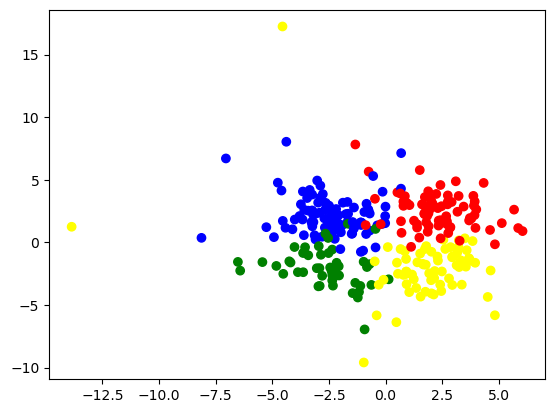

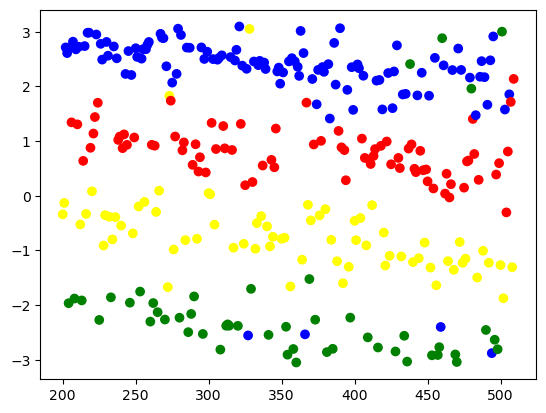

[0.041935483870967745, 0.11612903225806452, 0.06451612903225806, 0.07096774193548387, 0.07741935483870968, 0.0935483870967742, 0.0967741935483871, 0.15483870967741936, 0.035483870967741936, 0.12580645161290321, 0.08387096774193549, 0.14193548387096774, 0.08064516129032258, 0.0967741935483871, 0.15806451612903225, 0.08064516129032258, 0.08387096774193549, 0.18387096774193548, 0.05161290322580645, 0.14516129032258066, 0.09032258064516129, 0.08709677419354839, 0.08709677419354839, 0.15483870967741936, 0.06451612903225806, 0.08387096774193549, 0.08064516129032258, 0.12258064516129032, 0.06451612903225806, 0.13548387096774195, 0.07096774193548387, 0.1, 0.06774193548387097, 0.08387096774193549, 0.08064516129032258, 0.14516129032258066, 0.07096774193548387, 0.13870967741935483, 0.09032258064516129, 0.11290322580645161, 0.07096774193548387, 0.05806451612903226, 0.0967741935483871, 0.09032258064516129, 0.07741935483870968, 0.08387096774193549, 0.06451612903225806, 0.1064516129032258, 0.12580645

In [27]:

error_rate = []
centres = []
past_angle = 0
past_gradient = 0
known_values = [200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500]
for i in range(0, 250):
    n = 1056
    index = i
    Symbol_Two = y[Start_index + index*n :Start_index + (index+1)*n]
    Symbol_Two = Symbol_Two[32:]
    Symbol_Two = np.fft.fft(Symbol_Two, n = 1024)
    Symbol_Two_correct_2 = Symbol_Two / chanel_estimation_2
    centrest = []
    corrected = []
    constelatons = np.loadtxt("constelations.txt", dtype=str) # transmitted bee.txt data constellation stars
    constelatons = constelatons[index*511:(index+1)*511]
    colours = []
    actual_vales = []
    for i in constelatons:
        if i == 'A':
            actual_vales.append((1 + 1j)/np.sqrt(2))
            colours.append('red')
        if i == 'B':
            actual_vales.append((-1 + 1j)/np.sqrt(2))
            colours.append('blue')
        if i == 'C':
            actual_vales.append((-1 - 1j)/np.sqrt(2))
            colours.append('green')
        if i == 'D':
            actual_vales.append((1 - 1j)/np.sqrt(2))
            colours.append('yellow')
    actual_vales = np.array(actual_vales)
    actual_vales = actual_vales[known_values]
    corrected = Symbol_Two_correct_2[1:512]
    past_gradient, corrected, final_corrected, diff, grad, intercept  = gradient_correction(past_gradient, Symbol_Two_correct_2[1:512], actual_vales, known_values)    
    #centrest, past_angle, corrected = phase_correction(centres, past_angle,corrected)
    #centres, past_angle, past_gradient, corrected, fnial_corrected = combined_correction(centres, past_angle, past_gradient, corrected)

    
    #centres = centrest
    index_1 = 200
    index_2 = 510
    error = 0
    e_corrected = corrected[index_1:index_2]
    constelatons = constelatons[index_1:index_2]
    decoded = []
    for x in e_corrected:
        if np.real(x) > 0 and np.imag(x) > 0:
            decoded.append('A')
        elif np.real(x) < 0 and np.imag(x) > 0:
            decoded.append('B')
        elif np.real(x) < 0 and np.imag(x) < 0:
            decoded.append('C')
        elif np.real(x) > 0 and np.imag(x) < 0:
            decoded.append('D')
    decoded = np.array(decoded)
    for i in range(len(decoded)):
        if decoded[i] != constelatons[i]:
            error += 1

    error_rate.append(error/len(e_corrected))
    if False:
        print(past_gradient)
        #pi_divided_8_line = np.arange(-10, 10) + 1j*np.arange(-10, 10)
        #plt.plot(np.real(pi_divided_8_line), np.imag(pi_divided_8_line))
        plt.scatter(np.real(corrected[index_1:index_2]), np.imag(corrected[index_1:index_2]), c = colours[index_1:index_2])
        plt.show()
        list_phase = []
        for x in range(index_1,index_2):
            phase = np.angle(corrected[x])
            list_phase.append(phase)
        frequency_bins = np.arange(index_1, index_2, 1).tolist()
        plt.scatter(frequency_bins, list_phase, c = colours[index_1:index_2])
        plt.show()
        plt.scatter(np.real(Symbol_Two_correct_2[index_1+1:index_2+1]), np.imag(Symbol_Two_correct_2[index_1+1:index_2+1]), c = colours[index_1:index_2])
        plt.show()
        list_phase = [] # list of phase of all received data
        for x in range(index_1,index_2):
            phase = np.angle(Symbol_Two_correct_2[x+1])
            list_phase.append(phase)
        frequency_bins = np.arange(index_1, index_2, 1).tolist()
        plt.scatter(frequency_bins, list_phase, c = colours[index_1:index_2])
        plt.show()
    if 220 < index < 240:

        print(past_gradient)
        #print(centres)
        plt.scatter(np.real(corrected[index_1:index_2]), np.imag(corrected[index_1:index_2]), c = colours[index_1:index_2])
        plt.show()
        list_phase = []
        for x in range(index_1,index_2):
            phase = np.angle(corrected[x])
            list_phase.append(phase)
        frequency_bins = np.arange(index_1, index_2, 1).tolist()
        plt.scatter(frequency_bins, list_phase, c = colours[index_1:index_2])
        plt.show()
        """plt.scatter(np.real(Symbol_Two_correct_2[index_1+1:index_2+1]), np.imag(Symbol_Two_correct_2[index_1+1:index_2+1]), c = colours[index_1:index_2])
        plt.show()
        list_phase = [] # list of phase of all received data
        for x in range(index_1,index_2):
            phase = np.angle(Symbol_Two_correct_2[x+1])
            list_phase.append(phase)
        frequency_bins = np.arange(index_1, index_2, 1).tolist()
        plt.scatter(frequency_bins, list_phase, c = colours[index_1:index_2])
        plt.show()"""

# -0.0003799015211011235 0.04182666061702825
print(error_rate)
# R Y G B
# -0.0020769395047429066 0.5053110005903971
# -0.0003799015211011235 0.04182666061702825

Method 3: known pilots + phase correction (GRAPH)

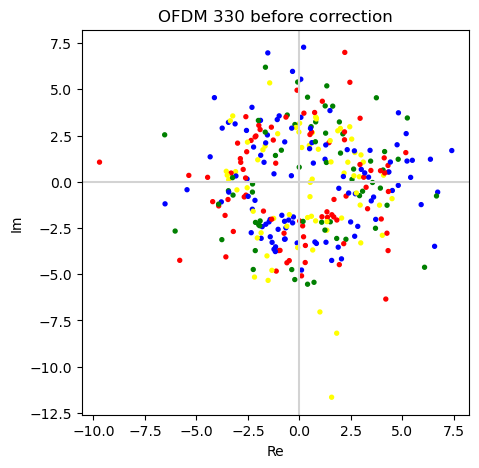

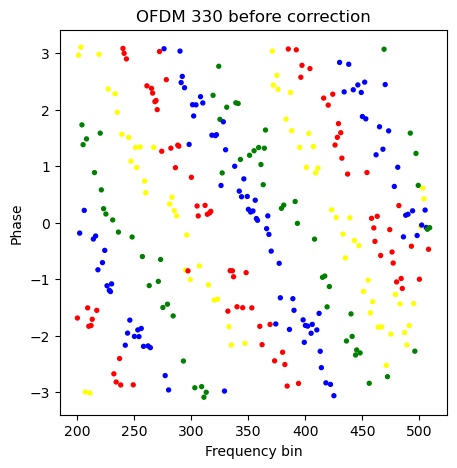

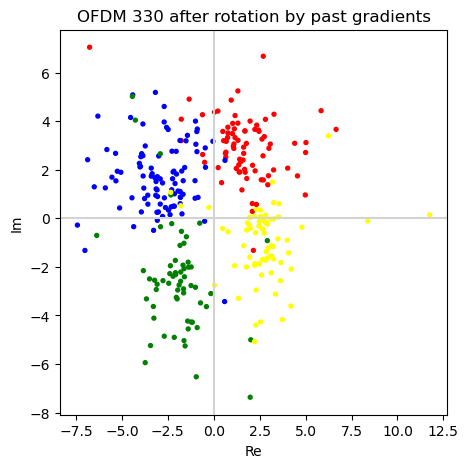

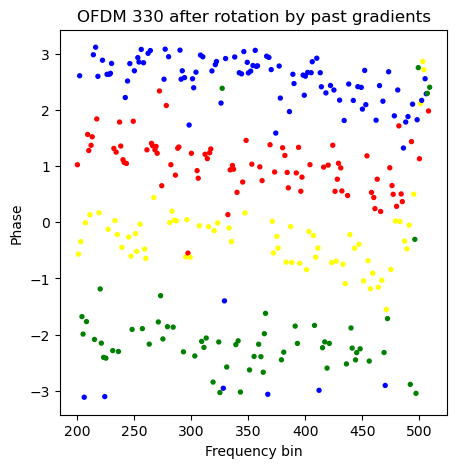

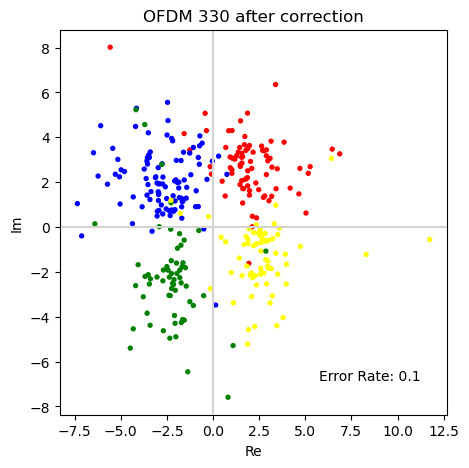

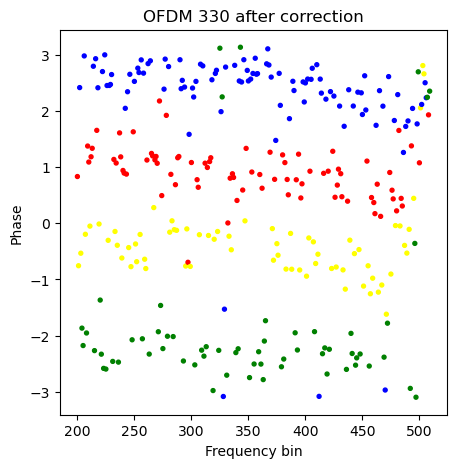

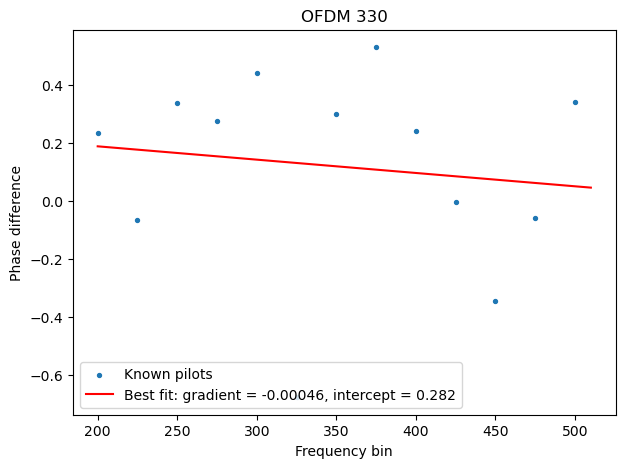

In [28]:
error_rate = []
centres = []
past_angle = 0
past_gradient = 0
known_values = [200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500]
for i in range(0, 377):
    n = 1056
    index = i
    Symbol_Two = y[Start_index + index*n :Start_index + (index+1)*n]
    Symbol_Two = Symbol_Two[32:]
    Symbol_Two = np.fft.fft(Symbol_Two, n = 1024)
    Symbol_Two_correct_2 = Symbol_Two / chanel_estimation_2
    centrest = []
    corrected = []
    constelatons = np.loadtxt("constelations.txt", dtype=str) # transmitted bee.txt data constellation stars
    constelatons = constelatons[index*511:(index+1)*511]
    colours = []
    actual_vales = []
    for i in constelatons:
        if i == 'A':
            actual_vales.append((1 + 1j)/np.sqrt(2))
            colours.append('red')
        if i == 'B':
            actual_vales.append((-1 + 1j)/np.sqrt(2))
            colours.append('blue')
        if i == 'C':
            actual_vales.append((-1 - 1j)/np.sqrt(2))
            colours.append('green')
        if i == 'D':
            actual_vales.append((1 - 1j)/np.sqrt(2))
            colours.append('yellow')
    actual_vales = np.array(actual_vales)
    actual_vales = actual_vales[known_values]
    corrected = Symbol_Two_correct_2[1:512]

    # choose phase correction method 
    past_gradient, corrected, final_corrected, diff, grad, intercept = gradient_correction(past_gradient, Symbol_Two_correct_2[1:512], actual_vales, known_values)    
    #centrest, past_angle, corrected = phase_correction(centres, past_angle,corrected)
    
    #centres = centrest
    index_1 = 200
    index_2 = 510

    error = 0
    e_corrected = final_corrected[index_1:index_2]
    constelatons = constelatons[index_1:index_2]
    decoded = []
    for x in e_corrected:
        if np.real(x) > 0 and np.imag(x) > 0:
            decoded.append('A')
        elif np.real(x) < 0 and np.imag(x) > 0:
            decoded.append('B')
        elif np.real(x) < 0 and np.imag(x) < 0:
            decoded.append('C')
        elif np.real(x) > 0 and np.imag(x) < 0:
            decoded.append('D')
    decoded = np.array(decoded)
    for i in range(len(decoded)):
        if decoded[i] != constelatons[i]:
            error += 1
    error_rate.append(error/len(e_corrected))

    if False:
        print(past_gradient)
        #pi_divided_8_line = np.arange(-10, 10) + 1j*np.arange(-10, 10)
        #plt.plot(np.real(pi_divided_8_line), np.imag(pi_divided_8_line))
        plt.scatter(np.real(corrected[index_1:index_2]), np.imag(corrected[index_1:index_2]), c = colours[index_1:index_2])
        plt.show()
        list_phase = []
        for x in range(index_1,index_2):
            phase = np.angle(corrected[x])
            list_phase.append(phase)
        frequency_bins = np.arange(index_1, index_2, 1).tolist()
        plt.scatter(frequency_bins, list_phase, c = colours[index_1:index_2])
        plt.show()
        plt.scatter(np.real(Symbol_Two_correct_2[index_1+1:index_2+1]), np.imag(Symbol_Two_correct_2[index_1+1:index_2+1]), c = colours[index_1:index_2])
        plt.show()
        list_phase = [] # list of phase of all received data
        for x in range(index_1,index_2):
            phase = np.angle(Symbol_Two_correct_2[x+1])
            list_phase.append(phase)
        frequency_bins = np.arange(index_1, index_2, 1).tolist()
        plt.scatter(frequency_bins, list_phase, c = colours[index_1:index_2])
        plt.show()
    if index in [330]: # choose what OFDM index to show 

        # print(past_gradient)
        plt.figure(figsize=(5, 5))
        plt.scatter(np.real(Symbol_Two_correct_2[index_1+1:index_2+1]), np.imag(Symbol_Two_correct_2[index_1+1:index_2+1]), c=colours[index_1:index_2], s=8)
        plt.axhline(y=0, color='lightgrey')
        plt.axvline(x=0, color='lightgrey')
        # plt.title(f" Constellation of OFDM index {index} before correction")
        plt.title(f"OFDM {index} before correction")
        plt.xlabel("Re")
        plt.ylabel("Im")
        plt.show()

        list_phase_bef_correction = []
        for x in range(index_1,index_2):
            phase = np.angle(Symbol_Two_correct_2[x+1])
            list_phase_bef_correction.append(phase)
        frequency_bins = np.arange(index_1, index_2, 1).tolist()
        plt.figure(figsize=(5, 5))
        plt.scatter(frequency_bins, list_phase_bef_correction, c = colours[index_1:index_2], s=8)
        plt.title(f"OFDM {index} before correction")
        # plt.title(f"Phase plot of OFDM index {index} before correction")
        plt.xlabel("Frequency bin")
        plt.ylabel("Phase")
        plt.show()

        plt.figure(figsize=(5, 5))
        plt.scatter(np.real(corrected[index_1:index_2]), np.imag(corrected[index_1:index_2]), c = colours[index_1:index_2], s=8)
        # plt.title(f" Constellation of OFDM index {index} after rotation by past gradients")
        plt.title(f"OFDM {index} after rotation by past gradients")
        plt.axhline(y=0, color='lightgrey')
        plt.axvline(x=0, color='lightgrey')
        plt.xlabel("Re")
        plt.ylabel("Im")
        plt.show()
        
        list_phase_aft_rotation = []
        for x in range(index_1,index_2):
            phase = np.angle(corrected[x])
            list_phase_aft_rotation.append(phase)
        frequency_bins = np.arange(index_1, index_2, 1).tolist()
        plt.figure(figsize=(5, 5))
        plt.scatter(frequency_bins, list_phase_aft_rotation, c = colours[index_1:index_2], s=8)
        plt.title(f"OFDM {index} after rotation by past gradients")
        # plt.title(f"Phase plot of OFDM index {index} after rotation by past gradients")
        plt.xlabel("Frequency bin")
        plt.ylabel("Phase")
        plt.show()

        plt.figure(figsize=(5, 5))
        plt.scatter(np.real(final_corrected[index_1:index_2]), np.imag(final_corrected[index_1:index_2]), c = colours[index_1:index_2], s=8)
        error_rate_text = f"Error Rate: {round(error_rate[index],5)}"
        plt.text(0.8, 0.1, error_rate_text, ha='center', va='center', transform=plt.gca().transAxes, fontsize=10)
        # plt.title(f" Constellation of OFDM index {index} after correction")
        plt.title(f"OFDM {index} after correction")
        plt.axhline(y=0, color='lightgrey')
        plt.axvline(x=0, color='lightgrey')
        plt.xlabel("Re")
        plt.ylabel("Im")
        plt.show()
        
        list_phase_aft_correction = []
        for x in range(index_1,index_2):
            phase = np.angle(final_corrected[x])
            list_phase_aft_correction.append(phase)
        frequency_bins = np.arange(index_1, index_2, 1).tolist()
        plt.figure(figsize=(5, 5))
        plt.scatter(frequency_bins, list_phase_aft_correction, c = colours[index_1:index_2], s=8)
        plt.title(f"OFDM {index} after correction")
        # plt.title(f"Phase plot of OFDM index {index} after correction")
        plt.xlabel("Frequency bin")
        plt.ylabel("Phase")
        plt.show()

        plt.figure(figsize=(7, 5))
        plt.scatter(known_values, diff, s=8, label="Known pilots")

        x_bins = np.linspace(index_1, index_2, index_2-index_1)
        y_line = grad * x_bins + intercept

        plt.plot(x_bins, y_line, color='red', label=f'Best fit: gradient = {round(grad,5)}, intercept = {round(intercept,3)}')

        plt.title(f"OFDM {index}")
        # plt.title(f"Phase difference between known pilots and expected value in OFDM index {index}")
        plt.xlabel("Frequency bin")
        plt.ylabel("Phase difference")
        plt.legend()
        plt.show()


        #take the appropriate index gradient value from the list of gradients

        """plt.scatter(np.real(Symbol_Two_correct_2[index_1+1:index_2+1]), np.imag(Symbol_Two_correct_2[index_1+1:index_2+1]), c = colours[index_1:index_2])
        plt.show()
        list_phase = [] # list of phase of all received data
        for x in range(index_1,index_2):
            phase = np.angle(Symbol_Two_correct_2[x+1])
            list_phase.append(phase)
        frequency_bins = np.arange(index_1, index_2, 1).tolist()
        plt.scatter(frequency_bins, list_phase, c = colours[index_1:index_2])
        plt.show()"""


# print(error_rate)
# R Y G B


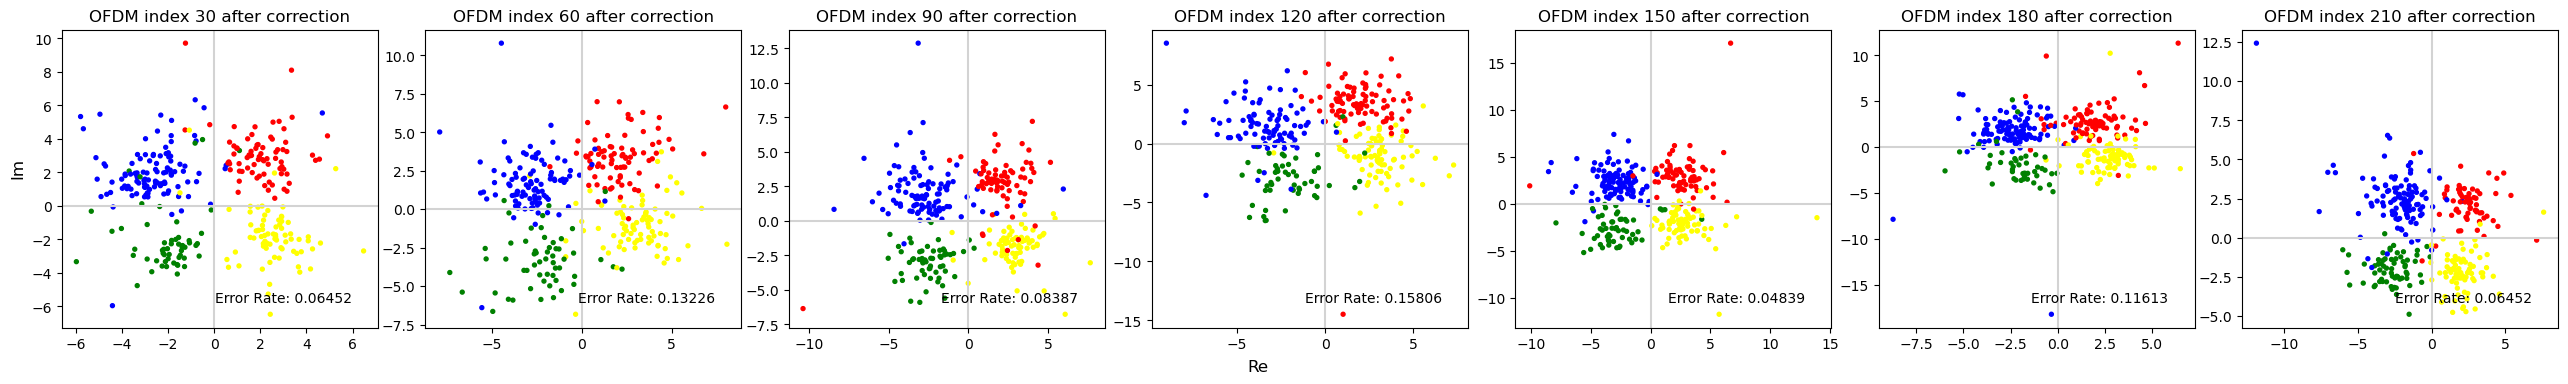

In [40]:
error_rate = []
centres = []
past_angle = 0
past_gradient = 0
known_values = [200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500]

fig, axes = plt.subplots(1, 7, figsize=(26, 4.2))
axes = axes.flatten()

for i in range(0, 377):
    n = 1056
    index = i
    Symbol_Two = y[Start_index + index*n :Start_index + (index+1)*n]
    Symbol_Two = Symbol_Two[32:]
    Symbol_Two = np.fft.fft(Symbol_Two, n = 1024)
    Symbol_Two_correct_2 = Symbol_Two / chanel_estimation_2
    centrest = []
    corrected = []
    constelatons = np.loadtxt("constelations.txt", dtype=str) # transmitted bee.txt data constellation stars
    constelatons = constelatons[index*511:(index+1)*511]
    colours = []
    actual_vales = []
    for i in constelatons:
        if i == 'A':
            actual_vales.append((1 + 1j)/np.sqrt(2))
            colours.append('red')
        if i == 'B':
            actual_vales.append((-1 + 1j)/np.sqrt(2))
            colours.append('blue')
        if i == 'C':
            actual_vales.append((-1 - 1j)/np.sqrt(2))
            colours.append('green')
        if i == 'D':
            actual_vales.append((1 - 1j)/np.sqrt(2))
            colours.append('yellow')
    actual_vales = np.array(actual_vales)
    actual_vales = actual_vales[known_values]
    corrected = Symbol_Two_correct_2[1:512]

    # choose phase correction method 
    past_gradient, corrected, final_corrected, diff, grad, intercept = gradient_correction(past_gradient, Symbol_Two_correct_2[1:512], actual_vales, known_values)    
    
    #centres = centrest
    index_1 = 200
    index_2 = 510

    error = 0
    e_corrected = final_corrected[index_1:index_2]
    constelatons = constelatons[index_1:index_2]
    decoded = []
    for x in e_corrected:
        if np.real(x) > 0 and np.imag(x) > 0:
            decoded.append('A')
        elif np.real(x) < 0 and np.imag(x) > 0:
            decoded.append('B')
        elif np.real(x) < 0 and np.imag(x) < 0:
            decoded.append('C')
        elif np.real(x) > 0 and np.imag(x) < 0:
            decoded.append('D')
    decoded = np.array(decoded)
    for i in range(len(decoded)):
        if decoded[i] != constelatons[i]:
            error += 1
    error_rate.append(error/len(e_corrected))

    indices = [30, 60, 90, 120, 150, 180, 210] # choose what OFDM index to show 
    if index in indices: 

        ax = axes[indices.index(index)]  # Get the corresponding subplot
        ax.scatter(np.real(final_corrected[index_1:index_2]), np.imag(final_corrected[index_1:index_2]), c=colours[index_1:index_2], s=8)
        ax.text(0.7, 0.1, f"Error Rate: {round(error_rate[index], 5)}", ha='center', va='center', transform=ax.transAxes, fontsize=10)
        ax.axhline(y=0, color='lightgrey')
        ax.axvline(x=0, color='lightgrey')
        ax.set_title(f"OFDM index {index} after correction")

fig.supxlabel("Re", fontsize="large")
fig.supylabel("Im", fontsize="large")
# fig.suptitle("Phase plots constellation stars", fontsize="x-large")
fig.subplots_adjust(left=0.04, right=1, top=0.83, bottom=0.12, wspace=0.15)
plt.show()

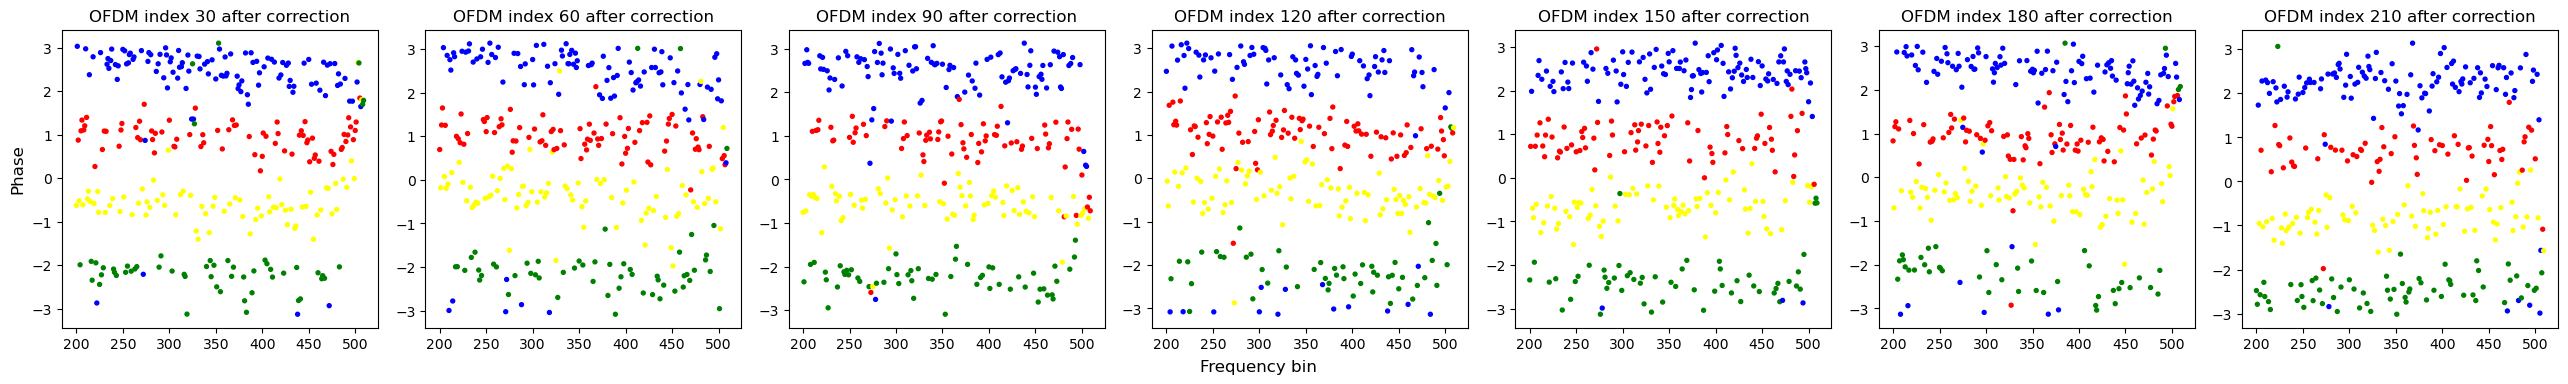

In [39]:
error_rate = []
centres = []
past_angle = 0
past_gradient = 0
known_values = [200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500]
fig, axes = plt.subplots(1, 7, figsize=(26, 4.2))
axes = axes.flatten()

for i in range(0, 377):
    n = 1056
    index = i
    Symbol_Two = y[Start_index + index*n :Start_index + (index+1)*n]
    Symbol_Two = Symbol_Two[32:]
    Symbol_Two = np.fft.fft(Symbol_Two, n = 1024)
    Symbol_Two_correct_2 = Symbol_Two / chanel_estimation_2
    centrest = []
    corrected = []
    constelatons = np.loadtxt("constelations.txt", dtype=str) # transmitted bee.txt data constellation stars
    constelatons = constelatons[index*511:(index+1)*511]
    colours = []
    actual_vales = []
    for i in constelatons:
        if i == 'A':
            actual_vales.append((1 + 1j)/np.sqrt(2))
            colours.append('red')
        if i == 'B':
            actual_vales.append((-1 + 1j)/np.sqrt(2))
            colours.append('blue')
        if i == 'C':
            actual_vales.append((-1 - 1j)/np.sqrt(2))
            colours.append('green')
        if i == 'D':
            actual_vales.append((1 - 1j)/np.sqrt(2))
            colours.append('yellow')
    actual_vales = np.array(actual_vales)
    actual_vales = actual_vales[known_values]
    corrected = Symbol_Two_correct_2[1:512]

    # choose phase correction method 
    past_gradient, corrected, final_corrected, diff, grad, intercept = gradient_correction(past_gradient, Symbol_Two_correct_2[1:512], actual_vales, known_values)    
    
    #centres = centrest
    index_1 = 200
    index_2 = 510

    indices = [30, 60, 90, 120, 150, 180, 210] # choose what OFDM index to show 
    if index in indices: 

        list_phase_aft_correction = []
        for x in range(index_1,index_2):
            phase = np.angle(final_corrected[x])
            list_phase_aft_correction.append(phase)
        frequency_bins = np.arange(index_1, index_2, 1).tolist()
        
        ax = axes[indices.index(index)]
        ax.scatter(frequency_bins, list_phase_aft_correction, c = colours[index_1:index_2], s=8)
        ax.set_title(f"OFDM index {index} after correction")
        # plt.title(f"Phase plot of OFDM index {index} after correction")

fig.supxlabel("Frequency bin", fontsize="large")
fig.supylabel("Phase", fontsize="large")
# fig.suptitle("Phase plots constellation stars", fontsize="x-large")
fig.subplots_adjust(left=0.04, right=1, top=0.83, bottom=0.12, wspace=0.15)
plt.show()


Method 4: k means + phase correction (GRAPH)

c:\Users\Yuxuan Xie\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Yuxuan Xie\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1362: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Yuxuan Xie\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Yuxuan Xie\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1362: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Yuxuan Xi

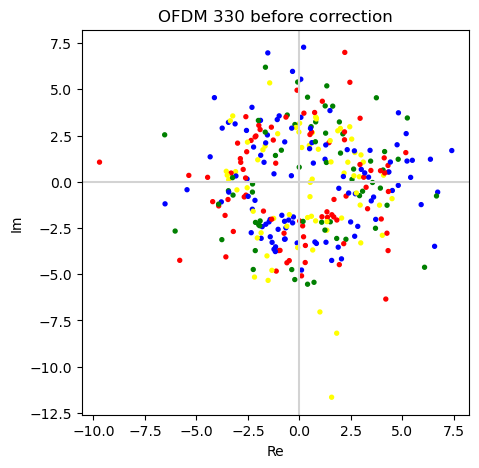

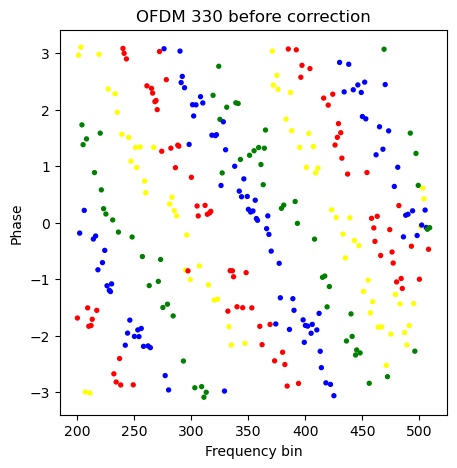

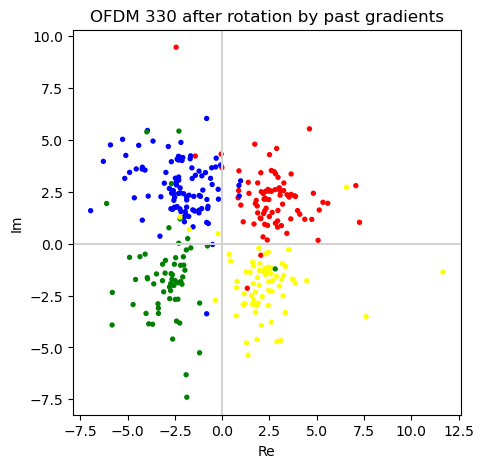

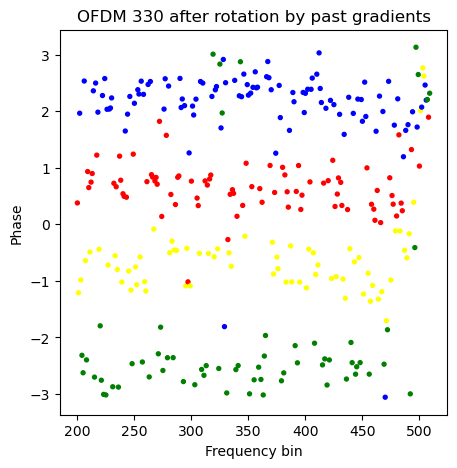

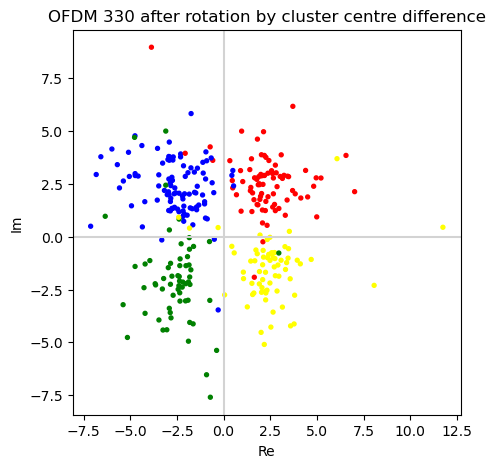

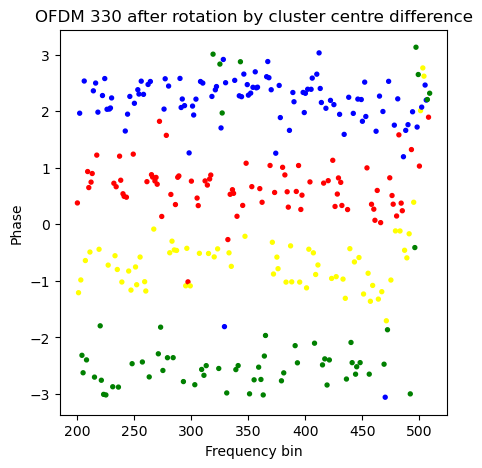

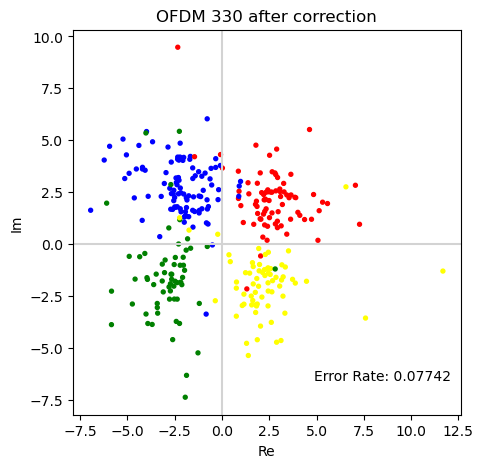

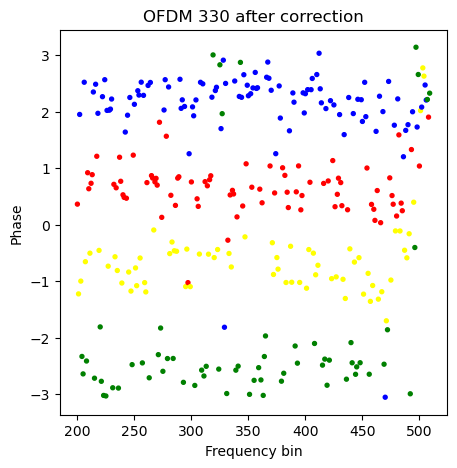

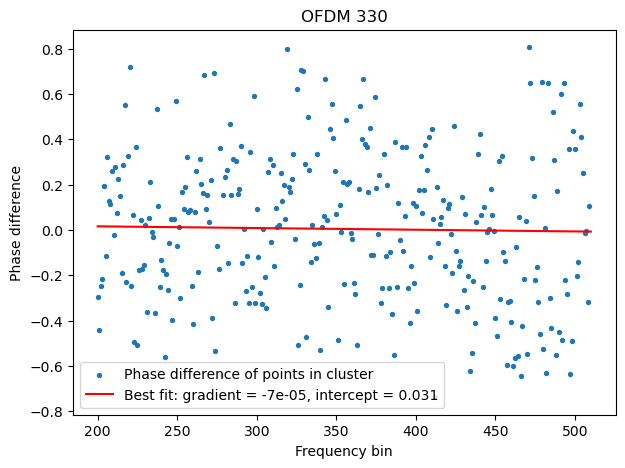

c:\Users\Yuxuan Xie\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Yuxuan Xie\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1362: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Yuxuan Xie\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Yuxuan Xie\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1362: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Yuxuan Xi

In [55]:
error_rate = []
centres = []
past_angle = 0
past_gradient = 0
for i in range(0, 377):
    n = 1056
    index = i
    Symbol_Two = y[Start_index + index*n :Start_index + (index+1)*n]
    Symbol_Two = Symbol_Two[32:]
    Symbol_Two = np.fft.fft(Symbol_Two, n = 1024)
    Symbol_Two_correct_2 = Symbol_Two / chanel_estimation_2
    centrest = []
    corrected = []
    constelatons = np.loadtxt("constelations.txt", dtype=str) # transmitted bee.txt data constellation stars
    constelatons = constelatons[index*511:(index+1)*511]
    colours = []
    actual_vales = []
    for i in constelatons:
        if i == 'A':
            actual_vales.append((1 + 1j)/np.sqrt(2))
            colours.append('red')
        if i == 'B':
            actual_vales.append((-1 + 1j)/np.sqrt(2))
            colours.append('blue')
        if i == 'C':
            actual_vales.append((-1 - 1j)/np.sqrt(2))
            colours.append('green')
        if i == 'D':
            actual_vales.append((1 - 1j)/np.sqrt(2))
            colours.append('yellow')
    actual_vales = np.array(actual_vales)
    actual_vales = actual_vales[known_values]
    corrected = Symbol_Two_correct_2[1:512]

    # choose phase correction method 
    #centrest, past_angle, corrected = phase_correction(centres, past_angle,corrected)
    centres, past_angle, past_gradient, corrected, intermediate_corrected, final_corrected, diff, intercept, grad = combined_correction(centres, past_angle, past_gradient, corrected)
    
    #centres = centrest
    index_1 = 200
    index_2 = 510

    error = 0
    e_corrected = final_corrected[index_1:index_2]
    constelatons = constelatons[index_1:index_2]
    decoded = []
    for x in e_corrected:
        if np.real(x) > 0 and np.imag(x) > 0:
            decoded.append('A')
        elif np.real(x) < 0 and np.imag(x) > 0:
            decoded.append('B')
        elif np.real(x) < 0 and np.imag(x) < 0:
            decoded.append('C')
        elif np.real(x) > 0 and np.imag(x) < 0:
            decoded.append('D')
    decoded = np.array(decoded)
    for i in range(len(decoded)):
        if decoded[i] != constelatons[i]:
            error += 1
    error_rate.append(error/len(e_corrected))

    if False:
        print(past_gradient)
        #pi_divided_8_line = np.arange(-10, 10) + 1j*np.arange(-10, 10)
        #plt.plot(np.real(pi_divided_8_line), np.imag(pi_divided_8_line))
        plt.scatter(np.real(corrected[index_1:index_2]), np.imag(corrected[index_1:index_2]), c = colours[index_1:index_2])
        plt.show()
        list_phase = []
        for x in range(index_1,index_2):
            phase = np.angle(corrected[x])
            list_phase.append(phase)
        frequency_bins = np.arange(index_1, index_2, 1).tolist()
        plt.scatter(frequency_bins, list_phase, c = colours[index_1:index_2])
        plt.show()
        plt.scatter(np.real(Symbol_Two_correct_2[index_1+1:index_2+1]), np.imag(Symbol_Two_correct_2[index_1+1:index_2+1]), c = colours[index_1:index_2])
        plt.show()
        list_phase = [] # list of phase of all received data
        for x in range(index_1,index_2):
            phase = np.angle(Symbol_Two_correct_2[x+1])
            list_phase.append(phase)
        frequency_bins = np.arange(index_1, index_2, 1).tolist()
        plt.scatter(frequency_bins, list_phase, c = colours[index_1:index_2])
        plt.show()
    if index in [330]: # choose what OFDM index to show 

        # print(past_gradient)
        plt.figure(figsize=(5, 5))
        plt.scatter(np.real(Symbol_Two_correct_2[index_1+1:index_2+1]), np.imag(Symbol_Two_correct_2[index_1+1:index_2+1]), c=colours[index_1:index_2], s=8)
        plt.axhline(y=0, color='lightgrey')
        plt.axvline(x=0, color='lightgrey')
        # plt.title(f" Constellation of OFDM index {index} before correction")
        plt.title(f"OFDM {index} before correction")
        plt.xlabel("Re")
        plt.ylabel("Im")
        plt.show()

        list_phase_bef_correction = []
        for x in range(index_1,index_2):
            phase = np.angle(Symbol_Two_correct_2[x+1])
            list_phase_bef_correction.append(phase)
        frequency_bins = np.arange(index_1, index_2, 1).tolist()
        plt.figure(figsize=(5, 5))
        plt.scatter(frequency_bins, list_phase_bef_correction, c = colours[index_1:index_2], s=8)
        plt.title(f"OFDM {index} before correction")
        # plt.title(f"Phase plot of OFDM index {index} before correction")
        plt.xlabel("Frequency bin")
        plt.ylabel("Phase")
        plt.show()

        plt.figure(figsize=(5, 5))
        plt.scatter(np.real(corrected[index_1:index_2]), np.imag(corrected[index_1:index_2]), c = colours[index_1:index_2], s=8)
        # plt.title(f" Constellation of OFDM index {index} after rotation by past gradients")
        plt.title(f"OFDM {index} after rotation by past gradients")
        plt.axhline(y=0, color='lightgrey')
        plt.axvline(x=0, color='lightgrey')
        plt.xlabel("Re")
        plt.ylabel("Im")
        plt.show()
        
        list_phase_aft_rotation = []
        for x in range(index_1,index_2):
            phase = np.angle(corrected[x])
            list_phase_aft_rotation.append(phase)
        frequency_bins = np.arange(index_1, index_2, 1).tolist()
        plt.figure(figsize=(5, 5))
        plt.scatter(frequency_bins, list_phase_aft_rotation, c = colours[index_1:index_2], s=8)
        plt.title(f"OFDM {index} after rotation by past gradients")
        # plt.title(f"Phase plot of OFDM index {index} after rotation by past gradients")
        plt.xlabel("Frequency bin")
        plt.ylabel("Phase")
        plt.show()

        plt.figure(figsize=(5, 5))
        plt.scatter(np.real(intermediate_corrected[index_1:index_2]), np.imag(intermediate_corrected[index_1:index_2]), c = colours[index_1:index_2], s=8)
        # plt.title(f" Constellation of OFDM index {index} after rotation by cluster centre difference")
        plt.title(f"OFDM {index} after rotation by cluster centre difference")
        plt.axhline(y=0, color='lightgrey')
        plt.axvline(x=0, color='lightgrey')
        plt.xlabel("Re")
        plt.ylabel("Im")
        plt.show()
        
        list_phase_aft_cluster_rotation = []
        for x in range(index_1,index_2):
            phase = np.angle(corrected[x])
            list_phase_aft_cluster_rotation.append(phase)
        frequency_bins = np.arange(index_1, index_2, 1).tolist()
        plt.figure(figsize=(5, 5))
        plt.scatter(frequency_bins, list_phase_aft_cluster_rotation, c = colours[index_1:index_2], s=8)
        plt.title(f"OFDM {index} after rotation by cluster centre difference")
        # plt.title(f"Phase plot of OFDM index {index} after rotation by cluster centre difference")
        plt.xlabel("Frequency bin")
        plt.ylabel("Phase")
        plt.show()

        plt.figure(figsize=(5, 5))
        plt.scatter(np.real(final_corrected[index_1:index_2]), np.imag(final_corrected[index_1:index_2]), c = colours[index_1:index_2], s=8)
        error_rate_text = f"Error Rate: {round(error_rate[index],5)}"
        plt.text(0.8, 0.1, error_rate_text, ha='center', va='center', transform=plt.gca().transAxes, fontsize=10)
        # plt.title(f" Constellation of OFDM index {index} after correction")
        plt.title(f"OFDM {index} after correction")
        plt.axhline(y=0, color='lightgrey')
        plt.axvline(x=0, color='lightgrey')
        plt.xlabel("Re")
        plt.ylabel("Im")
        plt.show()
        
        list_phase_aft_correction = []
        for x in range(index_1,index_2):
            phase = np.angle(final_corrected[x])
            list_phase_aft_correction.append(phase)
        frequency_bins = np.arange(index_1, index_2, 1).tolist()
        plt.figure(figsize=(5, 5))
        plt.scatter(frequency_bins, list_phase_aft_correction, c = colours[index_1:index_2], s=8)
        plt.title(f"OFDM {index} after correction")
        # plt.title(f"Phase plot of OFDM index {index} after correction")
        plt.xlabel("Frequency bin")
        plt.ylabel("Phase")
        plt.show()

        plt.figure(figsize=(7, 5))
        plt.scatter(np.arange(index_1, index_2), diff[index_1:index_2], s=8, label="Phase difference of points in cluster")

        x_bins = np.linspace(index_1, index_2, index_2-index_1)
        y_line = grad * x_bins + intercept

        plt.plot(x_bins, y_line, color='red', label=f'Best fit: gradient = {round(grad,5)}, intercept = {round(intercept,3)}')

        plt.title(f"OFDM {index}")
        # plt.title(f"Phase difference between all points in the cluster and expected value in OFDM index {index}")
        plt.xlabel("Frequency bin")
        plt.ylabel("Phase difference")
        plt.legend()
        plt.show()

        #take the appropriate index gradient value from the list of gradients

        """plt.scatter(np.real(Symbol_Two_correct_2[index_1+1:index_2+1]), np.imag(Symbol_Two_correct_2[index_1+1:index_2+1]), c = colours[index_1:index_2])
        plt.show()
        list_phase = [] # list of phase of all received data
        for x in range(index_1,index_2):
            phase = np.angle(Symbol_Two_correct_2[x+1])
            list_phase.append(phase)
        frequency_bins = np.arange(index_1, index_2, 1).tolist()
        plt.scatter(frequency_bins, list_phase, c = colours[index_1:index_2])
        plt.show()"""


# print(error_rate)
# R Y G B


In [56]:
error_rate = []
centres = []
past_angle = 0
past_gradient = 0
for i in range(0, 377):
    n = 1056
    index = i
    Symbol_Two = y[Start_index + index*n :Start_index + (index+1)*n]
    Symbol_Two = Symbol_Two[32:]
    Symbol_Two = np.fft.fft(Symbol_Two, n = 1024)
    Symbol_Two_correct_2 = Symbol_Two / chanel_estimation_2
    centrest = []
    corrected = []
    constelatons = np.loadtxt("constelations.txt", dtype=str) # transmitted bee.txt data constellation stars
    constelatons = constelatons[index*511:(index+1)*511]
    colours = []
    actual_vales = []
    for i in constelatons:
        if i == 'A':
            actual_vales.append((1 + 1j)/np.sqrt(2))
            colours.append('red')
        if i == 'B':
            actual_vales.append((-1 + 1j)/np.sqrt(2))
            colours.append('blue')
        if i == 'C':
            actual_vales.append((-1 - 1j)/np.sqrt(2))
            colours.append('green')
        if i == 'D':
            actual_vales.append((1 - 1j)/np.sqrt(2))
            colours.append('yellow')
    actual_vales = np.array(actual_vales)
    actual_vales = actual_vales[known_values]
    corrected = Symbol_Two_correct_2[1:512]

    # choose phase correction method 
    #centrest, past_angle, corrected = phase_correction(centres, past_angle,corrected)
    centres, past_angle, past_gradient, corrected, intermediate_corrected, final_corrected, diff, intercept, grad = combined_correction(centres, past_angle, past_gradient, corrected)
    
    #centres = centrest
    index_1 = 200
    index_2 = 510

    error = 0
    e_corrected = final_corrected[index_1:index_2]
    constelatons = constelatons[index_1:index_2]
    decoded = []
    for x in e_corrected:
        if np.real(x) > 0 and np.imag(x) > 0:
            decoded.append('A')
        elif np.real(x) < 0 and np.imag(x) > 0:
            decoded.append('B')
        elif np.real(x) < 0 and np.imag(x) < 0:
            decoded.append('C')
        elif np.real(x) > 0 and np.imag(x) < 0:
            decoded.append('D')
    decoded = np.array(decoded)
    for i in range(len(decoded)):
        if decoded[i] != constelatons[i]:
            error += 1
    error_rate.append(error/len(e_corrected))

    if False:
        print(past_gradient)
        #pi_divided_8_line = np.arange(-10, 10) + 1j*np.arange(-10, 10)
        #plt.plot(np.real(pi_divided_8_line), np.imag(pi_divided_8_line))
        plt.scatter(np.real(corrected[index_1:index_2]), np.imag(corrected[index_1:index_2]), c = colours[index_1:index_2])
        plt.show()
        list_phase = []
        for x in range(index_1,index_2):
            phase = np.angle(corrected[x])
            list_phase.append(phase)
        frequency_bins = np.arange(index_1, index_2, 1).tolist()
        plt.scatter(frequency_bins, list_phase, c = colours[index_1:index_2])
        plt.show()
        plt.scatter(np.real(Symbol_Two_correct_2[index_1+1:index_2+1]), np.imag(Symbol_Two_correct_2[index_1+1:index_2+1]), c = colours[index_1:index_2])
        plt.show()
        list_phase = [] # list of phase of all received data
        for x in range(index_1,index_2):
            phase = np.angle(Symbol_Two_correct_2[x+1])
            list_phase.append(phase)
        frequency_bins = np.arange(index_1, index_2, 1).tolist()
        plt.scatter(frequency_bins, list_phase, c = colours[index_1:index_2])
        plt.show()
    indices = [30, 60, 90, 120, 150, 180, 210] # choose what OFDM index to show 
    if index in indices: 

        ax = axes[indices.index(index)]  # Get the corresponding subplot
        ax.scatter(np.real(final_corrected[index_1:index_2]), np.imag(final_corrected[index_1:index_2]), c=colours[index_1:index_2], s=8)
        ax.text(0.7, 0.1, f"Error Rate: {round(error_rate[index], 5)}", ha='center', va='center', transform=ax.transAxes, fontsize=10)
        ax.axhline(y=0, color='lightgrey')
        ax.axvline(x=0, color='lightgrey')
        ax.set_title(f"OFDM index {index} after correction")

fig.supxlabel("Re", fontsize="large")
fig.supylabel("Im", fontsize="large")
# fig.suptitle("Phase plots constellation stars", fontsize="x-large")
fig.subplots_adjust(left=0.04, right=1, top=0.83, bottom=0.12, wspace=0.15)
plt.show()

c:\Users\Yuxuan Xie\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Yuxuan Xie\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1362: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Yuxuan Xie\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Yuxuan Xie\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1362: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Yuxuan Xi